#01_EDA

In [1]:
# 한글 폰트 관련
# 1. 나눔 폰트 설치
!apt-get -y install fonts-nanum

# 2. 런타임 재시작 없이 폰트 강제 등록
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

# 3. 폰트 경로 직접 지정
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
fm.fontManager.addfont(font_path)
nanum_font = fm.FontProperties(fname=font_path).get_name()

# 4. matplotlib 기본 설정에 강제로 반영
mpl.rcParams['font.family'] = nanum_font
mpl.rcParams['axes.unicode_minus'] = False


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (5,647 kB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 126371 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib


import sklearn
import xgboost
from xgboost import XGBRegressor


from sklearn.model_selection import KFold

import random as rn

RANDOM_SEED = 2025
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)



from datetime import datetime

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/dacon_2025_Power_usage_prediction_AI_github/2025dacon_powerU_github

/content/drive/MyDrive/dacon_2025_Power_usage_prediction_AI_github/2025dacon_powerU_github


In [5]:
!git config --global user.name "SonHyesang0914"
!git config --global user.email "hyesang0914@gmail.com"

In [6]:
train_path = "/content/drive/MyDrive/dacon_2025_Power_usage_prediction_AI/dacon_data/train.csv"
test_path = "/content/drive/MyDrive/dacon_2025_Power_usage_prediction_AI/dacon_data/test.csv"
building_info_path = "/content/drive/MyDrive/dacon_2025_Power_usage_prediction_AI/dacon_data/building_info.csv"

In [7]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
building_info = pd.read_csv(building_info_path)

In [8]:
#한글로 된 행 영어로 변환
train = train.rename(columns={
    '건물번호': 'building_num',
    '일시': 'date_time',
    '기온(°C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
train.drop('num_date_time', axis = 1, inplace=True)

test = test.rename(columns={
    '건물번호': 'building_num',
    '일시': 'date_time',
    '기온(°C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
test.drop('num_date_time', axis = 1, inplace=True)

building_info = building_info.rename(columns={
    '건물번호': 'building_num',
    '건물유형': 'building_type',
    '연면적(m2)': 'total_area',
    '냉방면적(m2)': 'cooling_area',
    '태양광용량(kW)': 'solar_power_capacity',
    'ESS저장용량(kWh)': 'ess_capacity',
    'PCS용량(kW)': 'pcs_capacity'
})

#한글로 된 건물 유형 영어로 변환
translation_dict = {
    '건물기타': 'Other_building',
    '공공': 'Public',
    '학교': 'University',
    '백화점': 'Department_store',
    '병원': 'Hospital',
    '상용': 'Commercial',
    '아파트': 'Apartment',
    '연구소': 'Laboratory',
    'IDC(전화국)': 'IDC',
    '호텔': 'Hotel'
}

building_info['building_type'] = building_info['building_type'].replace(translation_dict)

#태양광 기술이나 ess(pcs 포함)기술 유무 행 추가 있으면 1 없으면 0
#하는 이유? 단순 존재 여부 판단 편리 -> 시각화나 조건달 때 편리
#그리고 트리모델에서 더 잘 활용하기 위해 0과 1로 이분화
building_info['solar_power_include'] = np.where(building_info.solar_power_capacity !='-',1,0)
building_info['ess_include'] = np.where(building_info.ess_capacity !='-',1,0)

building_info = building_info.drop(columns=['solar_power_capacity', 'ess_capacity', 'pcs_capacity'], errors='ignore')

train = pd.merge(train, building_info, on='building_num', how='left')
test = pd.merge(test, building_info, on='building_num', how='left')

In [9]:
train['date_time'] = pd.to_datetime(train['date_time'], format='%Y%m%d %H')

# date time feature 생성
train['hour'] = train['date_time'].dt.hour
train['day'] = train['date_time'].dt.day
train['month'] = train['date_time'].dt.month
train['day_of_week'] = train['date_time'].dt.dayofweek #요일


test['date_time'] = pd.to_datetime(test['date_time'], format='%Y%m%d %H')

# date time feature 생성
test['hour'] = test['date_time'].dt.hour
test['day'] = test['date_time'].dt.day
test['month'] = test['date_time'].dt.month
test['day_of_week'] = test['date_time'].dt.dayofweek #요일

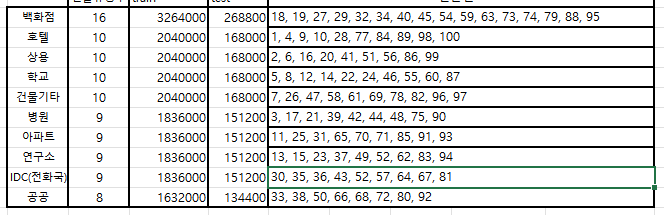


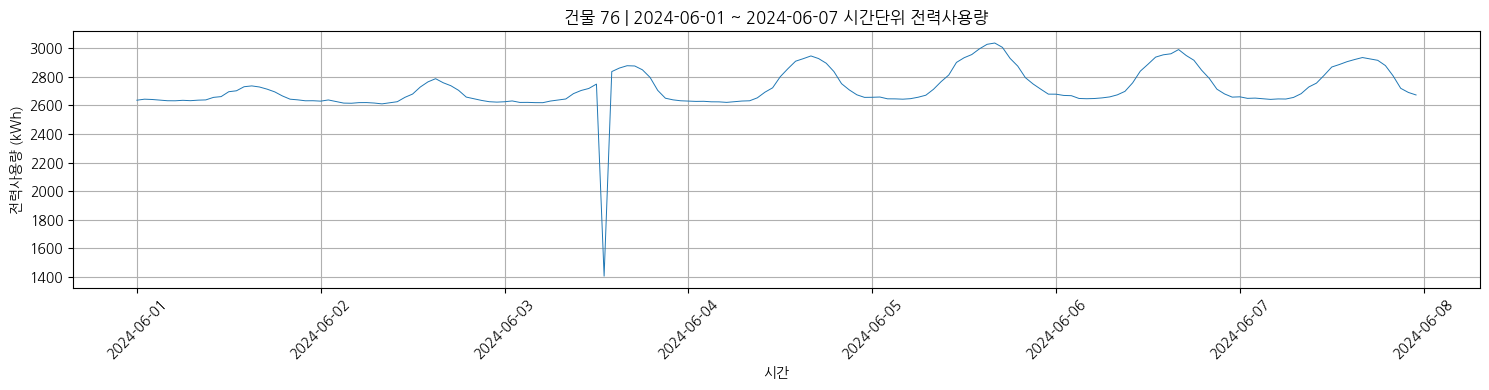

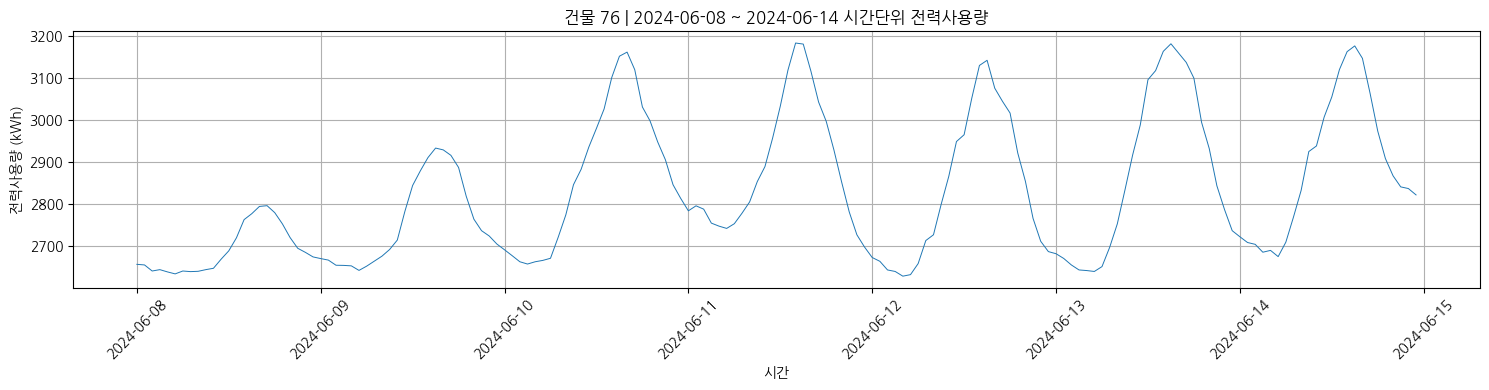

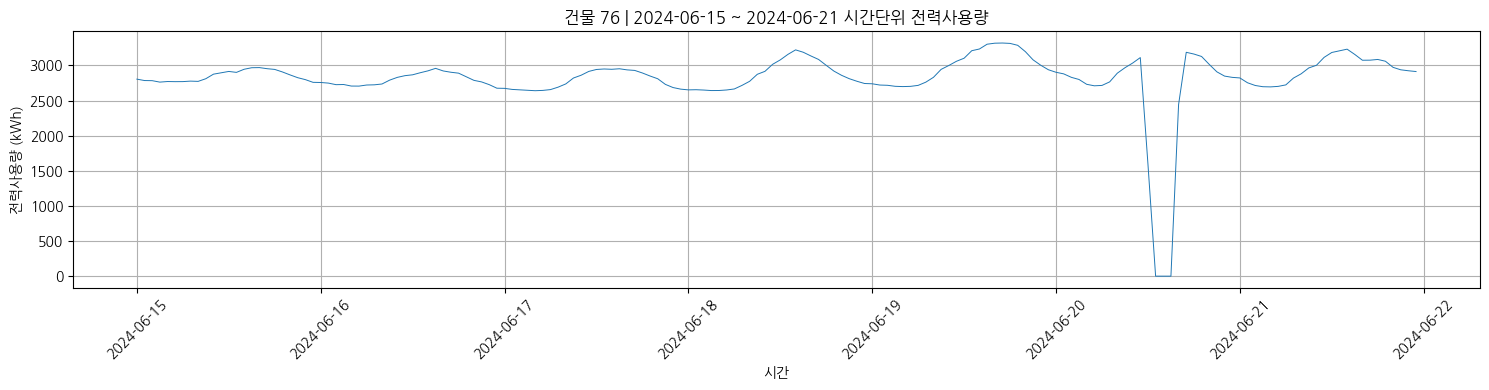

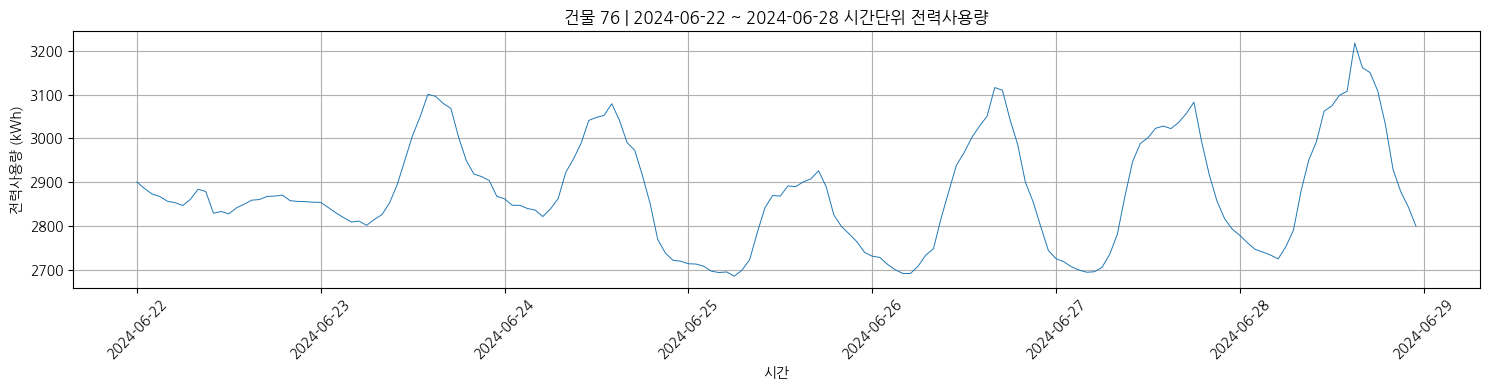

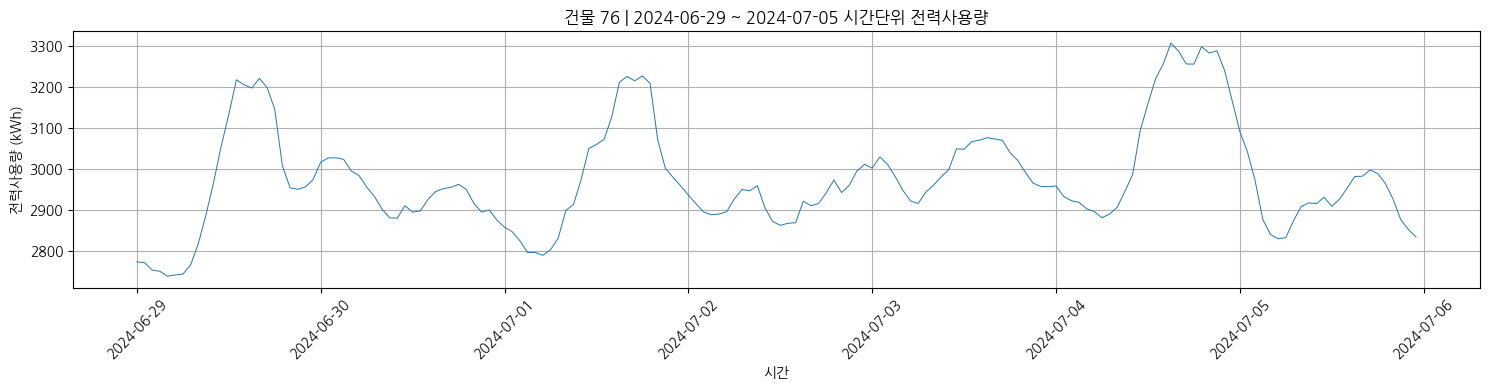

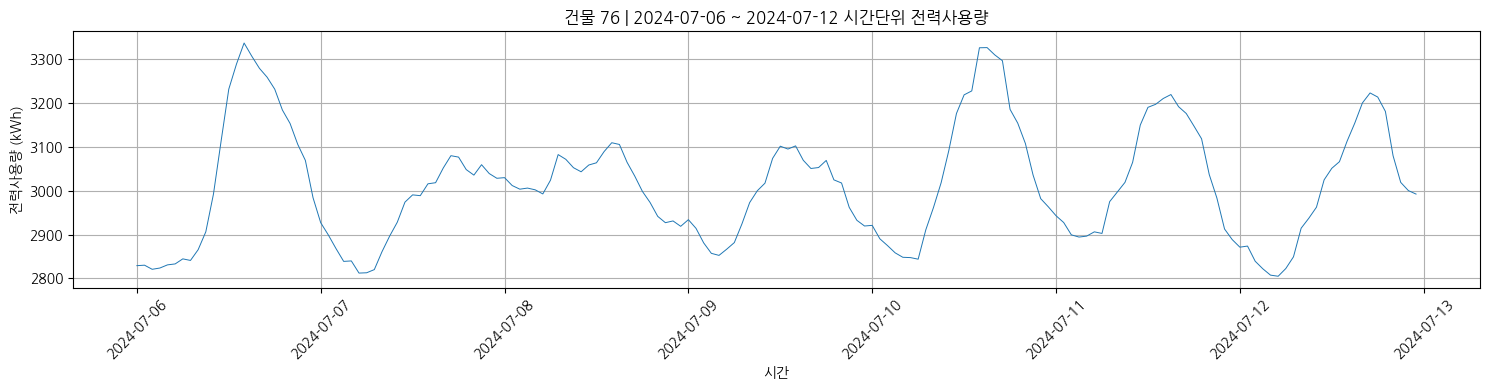

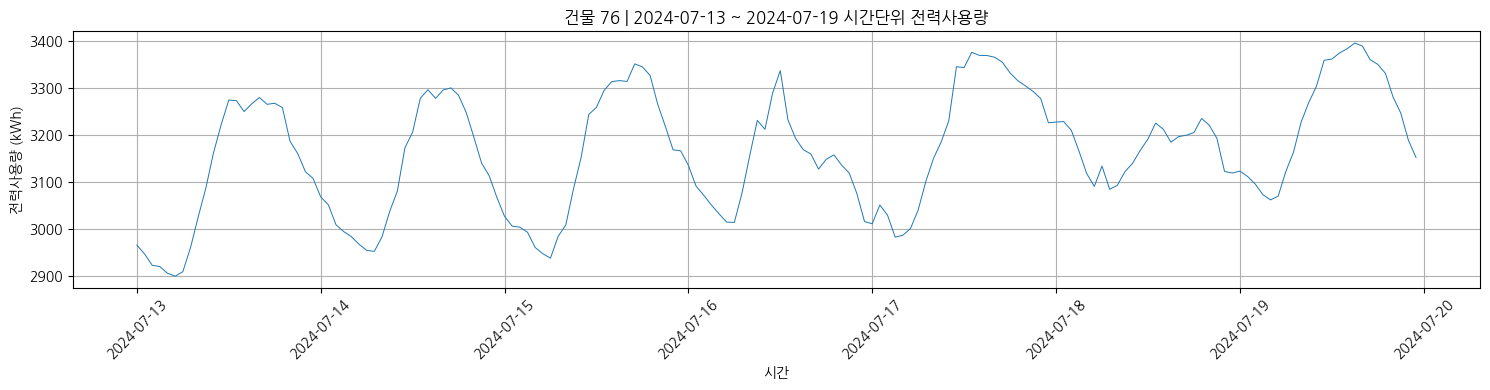

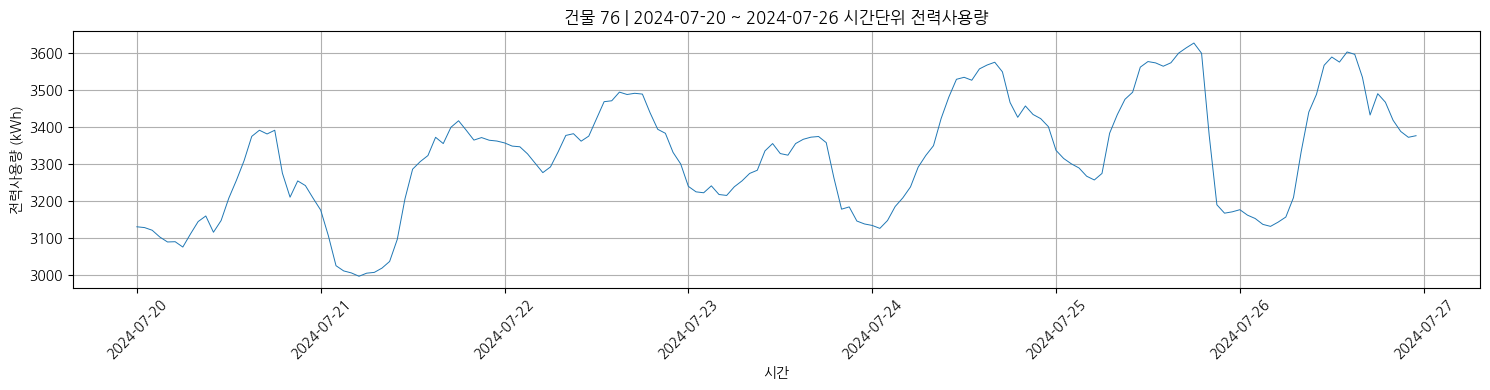

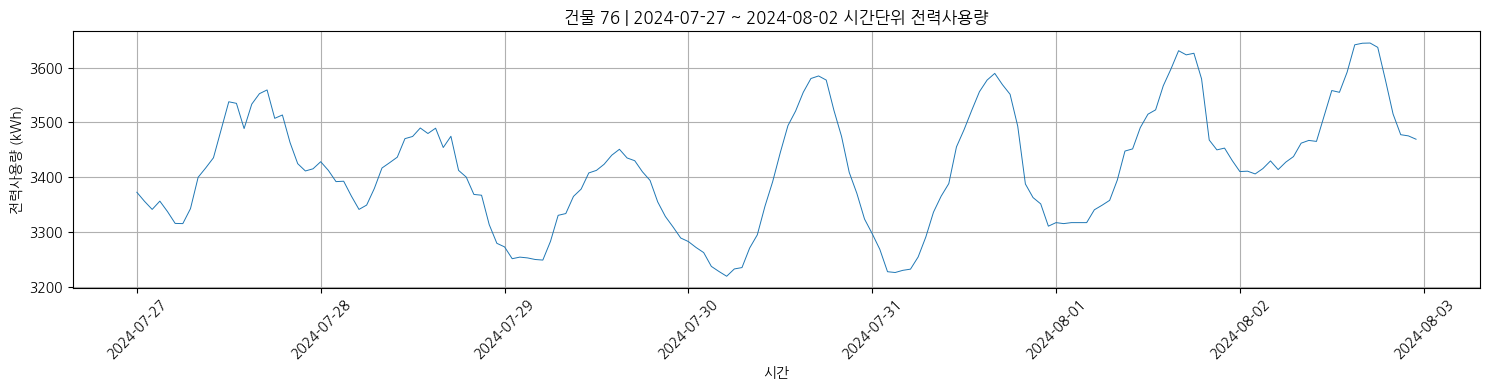

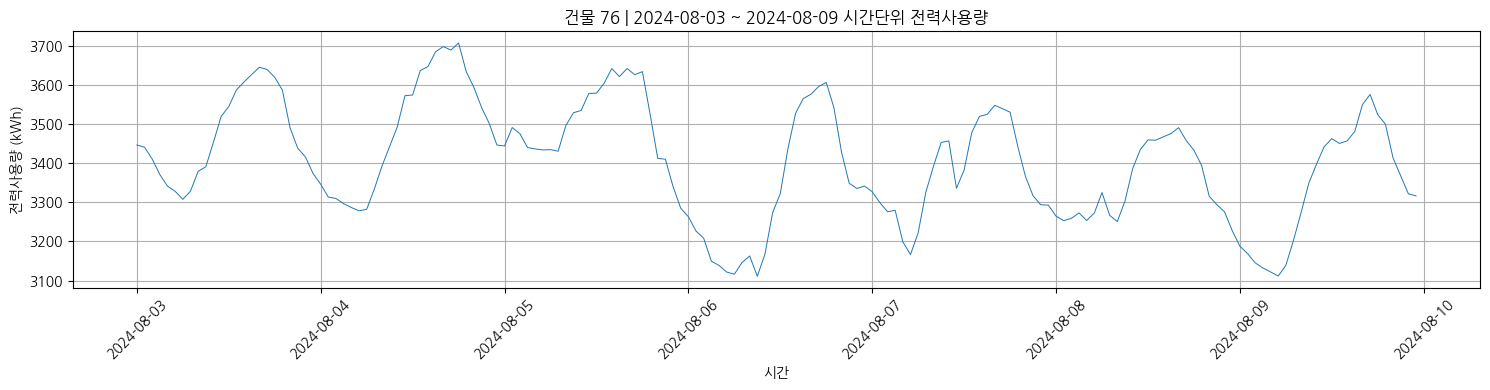

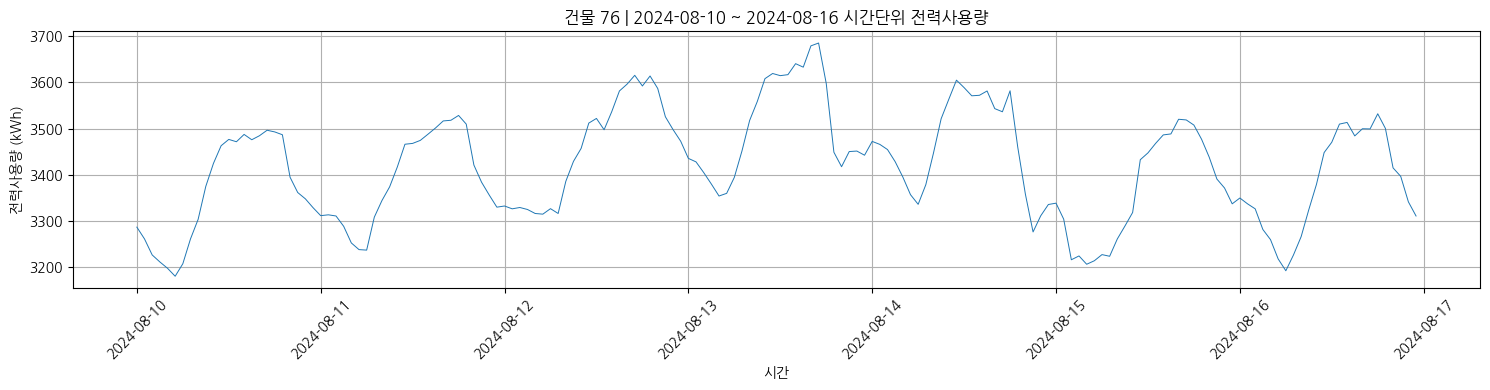

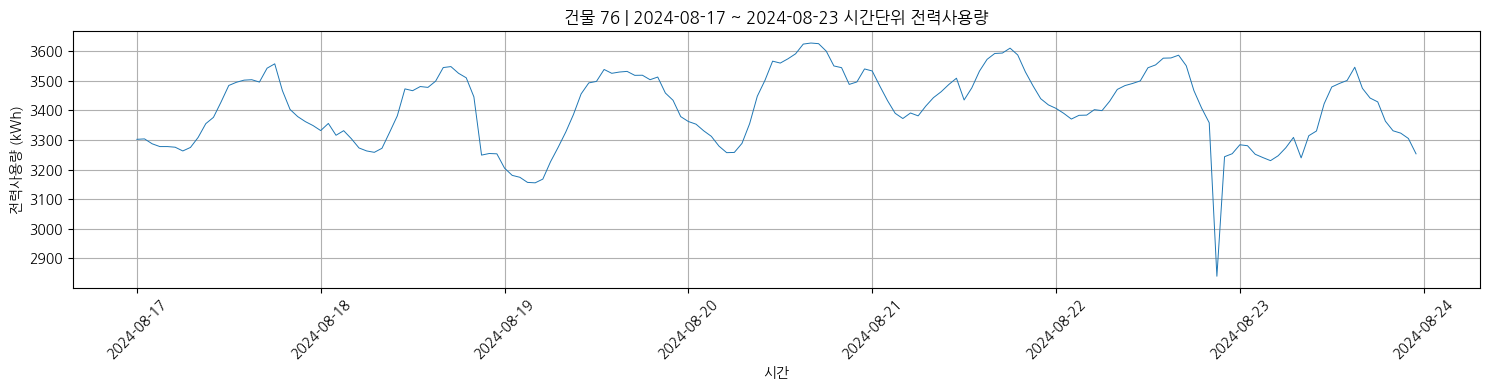

In [10]:
from datetime import timedelta

# 시작 날짜와 종료 날짜
start = train['date_time'].min().date()
end = train['date_time'].max().date()

b_id = 76

temp = train[train['building_num'] == b_id].copy()
temp = temp.sort_values('date_time')

# 주간 단위 반복
current = start
while current + timedelta(days=7) <= end:
    s = pd.to_datetime(current)
    e = pd.to_datetime(current + timedelta(days=7))

    week_temp = temp[(temp['date_time'] >= s) & (temp['date_time'] < e)]

    plt.figure(figsize=(15, 4))
    sns.lineplot(data=week_temp, x='date_time', y='power_consumption', linewidth=0.7)
    plt.title(f"건물 {b_id} | {s.date()} ~ {(e - timedelta(days=1)).date()} 시간단위 전력사용량")
    plt.xlabel("시간")
    plt.ylabel("전력사용량 (kWh)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    current += timedelta(days=7)


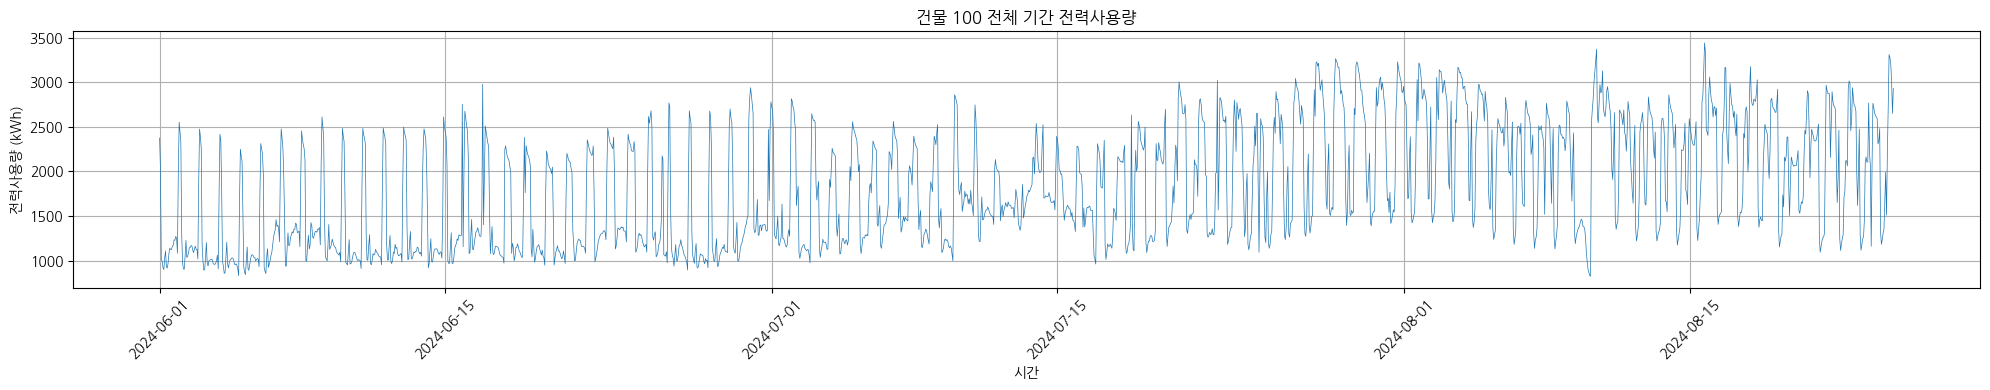

In [11]:
b_id = 100

temp = train[train['building_num'] == b_id].copy()

plt.figure(figsize=(20, 4))
sns.lineplot(data=temp, x='date_time', y='power_consumption', linewidth=0.5)
plt.title(f"건물 {b_id} 전체 기간 전력사용량")
plt.xlabel("시간")
plt.ylabel("전력사용량 (kWh)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
def overwrite_day_by_md(df, building, target_month, target_day, source_month, source_day,
                        col='power_consumption', keep_backup=True, log_list=None):
    """
    month/day 컬럼 기반으로 하루 단위 덮어쓰기
    building: 건물 번호(int)
    target_month, target_day: 덮어쓸 대상 월/일 (int)
    source_month, source_day: 덮어올 소스 월/일 (int)
    col: 덮을 컬럼명
    keep_backup: 원본 보관 여부
    log_list: 변경 이력 저장 리스트
    """
    m_src = (df['building_num']==building) & (df['month']==source_month) & (df['day']==source_day)
    m_tgt = (df['building_num']==building) & (df['month']==target_month) & (df['day']==target_day)

    n_src, n_tgt = m_src.sum(), m_tgt.sum()
    if n_src == 0 or n_tgt == 0:
        print(f"[WARN] 소스({n_src}), 타겟({n_tgt}) 행 없음")
        return df

    # 시간별 소스 값 준비
    src_hour_map = df.loc[m_src, ['hour', col]].set_index('hour')[col]

    # 덮어쓰기
    tgt_hours = df.loc[m_tgt, 'hour']
    new_vals = tgt_hours.map(src_hour_map)
    df.loc[m_tgt, col] = new_vals.fillna(df.loc[m_tgt, col]).values

    # 로그
    if log_list is not None:
        log_list.append({
            'building': building,
            'target_md': f"{target_month:02d}-{target_day:02d}",
            'source_md': f"{source_month:02d}-{source_day:02d}",
            'rows_changed': int(n_tgt),
            'column': col
        })
    return df


In [13]:
def plot_building_day(df, building_id, date, col='power_consumption'):
    """
    특정 건물 + 하루의 시간별 전력 사용량을 시각화
    df: 데이터프레임 (필수: building_num, date_time, col)
    building_id: int, 건물 번호
    date: 'YYYY-MM-DD' 형식 문자열 또는 datetime.date
    col: 전력 사용량 컬럼명 (기본 'power_consumption')
    """
    d = pd.to_datetime(date).date()

    temp = df[(df['building_num']==building_id) &
              (df['date_time'].dt.date == d)].copy()

    if temp.empty:
        print(f"[INFO] 해당 날짜에 데이터가 없습니다. 건물={building_id}, {d}")
        return

    temp = temp.sort_values('date_time')

    plt.figure(figsize=(12,4))
    sns.lineplot(data=temp, x='date_time', y=col, linewidth=1)
    plt.title(f"건물 {building_id} | {d} 하루 전력사용량")
    plt.xlabel("시간")
    plt.ylabel("전력사용량 (kWh)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [14]:
def plot_building_power(df, building_id, start_date, end_date, col='power_consumption'):
    """
    특정 건물 + 날짜 범위의 시간별 전력 사용량을 시각화
    df: 데이터프레임 (필수 컬럼: building_num, date_time, col)
    building_id: int, 건물 번호
    start_date, end_date: 'YYYY-MM-DD' 형식 문자열 또는 datetime/date
    col: 전력 사용량 컬럼명 (기본 'power_consumption')
    """
    # 날짜 처리
    s = pd.to_datetime(start_date)
    e = pd.to_datetime(end_date)

    temp = df[(df['building_num']==building_id) &
              (df['date_time'] >= s) & (df['date_time'] <= e)].copy()

    if temp.empty:
        print(f"[INFO] 해당 구간에 데이터가 없습니다. 건물={building_id}, {s.date()}~{e.date()}")
        return

    temp = temp.sort_values('date_time')

    plt.figure(figsize=(15,4))
    sns.lineplot(data=temp, x='date_time', y=col, linewidth=0.7)
    plt.title(f"건물 {building_id} | {s.date()} ~ {e.date()} 시간단위 전력사용량")
    plt.xlabel("시간")
    plt.ylabel("전력사용량 (kWh)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [15]:




def overwrite_by_ref_avg(df, building, month, day, target_hours, ref_hour1, ref_hour2,
                         col='power_consumption', keep_backup=True, log_list=None):
    """
    df: 시계열 데이터프레임 (필수 컬럼: building_num, month, day, hour, col)
    building: int, 건물번호
    month, day: int, 대상 날짜
    target_hours: int 또는 iterable(int), 바꿀 'hour' (예: 9 or [9,10,11])
    ref_hour1, ref_hour2: int, 기준 시간 2개 (같은 날짜에서 가져옴)
    col: 수정할 컬럼명 (기본 'power_consumption')
    log_list: 변경 이력 저장용 리스트(선택)
    """

    # hours 입력 정규화
    if isinstance(target_hours, (int, np.integer)):
        target_hours = [int(target_hours)]
    else:
        target_hours = list(target_hours)

    # 대상/기준 마스크
    m_day = (df['building_num']==building) & (df['month']==month) & (df['day']==day)

    # 기준값 확보
    m_ref1 = m_day & (df['hour']==int(ref_hour1))
    m_ref2 = m_day & (df['hour']==int(ref_hour2))

    if m_ref1.sum()==0 or m_ref2.sum()==0:
        print(f"[WARN] 기준시간 존재 안함 -> ref1({m_ref1.sum()}), ref2({m_ref2.sum()}) "
              f"[b={building}, {month:02d}-{day:02d}, ref={ref_hour1},{ref_hour2}]")
        return df

    ref_val1 = df.loc[m_ref1, col].iloc[0]
    ref_val2 = df.loc[m_ref2, col].iloc[0]

    if pd.isna(ref_val1) or pd.isna(ref_val2):
        print(f"[WARN] 기준시간 값이 NaN입니다. ref1={ref_val1}, ref2={ref_val2}")
        return df

    new_val = (float(ref_val1) + float(ref_val2)) / 2.0

    # 타깃 치환
    m_tgt = m_day & (df['hour'].isin(target_hours))
    changed_rows = int(m_tgt.sum())
    if changed_rows == 0:
        print(f"[INFO] 바꿀 시간대 행이 없습니다. [b={building}, {month:02d}-{day:02d}, hours={target_hours}]")
        return df

    df.loc[m_tgt, col] = new_val

    # 로그
    if log_list is not None:
        log_list.append({
            'building': int(building),
            'month': int(month),
            'day': int(day),
            'target_hours': list(map(int, target_hours)),
            'ref_hour1': int(ref_hour1),
            'ref_hour2': int(ref_hour2),
            'new_val': float(new_val),
            'rows_changed': changed_rows,
            'column': col
        })

    return df


In [16]:
def reduce_daytime_range(df, building, month, day, start_hour, end_hour,
                         reduce_val, col='power_consumption',
                         keep_backup=True, log_list=None):
    """
    특정 건물, 특정 날짜 하루에서 start_hour~end_hour 범위의 값에 일정 값을 빼줌
    df: DataFrame (필수 컬럼: building_num, month, day, hour, col)
    building: int, 건물번호
    month, day: int, 대상 날짜
    start_hour, end_hour: 시간 범위 (포함 조건, int)
    reduce_val: 빼줄 값
    col: 수정할 컬럼명
    log_list: 변경 이력 기록용 리스트
    """
    # 대상 마스크
    m = ((df['building_num']==building) &
         (df['month']==month) & (df['day']==day) &
         (df['hour']>=start_hour) & (df['hour']<=end_hour))

    df.loc[m, col] = df.loc[m, col] - reduce_val
    df.loc[m, col] = df.loc[m, col].clip(lower=0)  # 음수 방지

    if log_list is not None:
        log_list.append({
            'building': building,
            'month': month,
            'day': day,
            'start_hour': start_hour,
            'end_hour': end_hour,
            'reduce_val': reduce_val,
            'rows_changed': int(m.sum()),
            'column': col
        })
    return df


In [17]:
def increase_daytime_range(df, building, month, day, start_hour, end_hour,
                         increase_val, col='power_consumption',
                         keep_backup=True, log_list=None):
    """
    특정 건물, 특정 날짜 하루에서 start_hour~end_hour 범위의 값에 일정 값을 더해줌
    df: DataFrame (필수 컬럼: building_num, month, day, hour, col)
    building: int, 건물번호
    month, day: int, 대상 날짜
    start_hour, end_hour: 시간 범위 (포함 조건, int)
    increase_val: 더해줄 값
    col: 수정할 컬럼명
    log_list: 변경 이력 기록용 리스트
    """
    # 대상 마스크
    m = ((df['building_num']==building) &
         (df['month']==month) & (df['day']==day) &
         (df['hour']>=start_hour) & (df['hour']<=end_hour))

    df.loc[m, col] = df.loc[m, col] + increase_val
    df.loc[m, col] = df.loc[m, col].clip(lower=0)  # 음수 방지

    if log_list is not None:
        log_list.append({
            'building': building,
            'month': month,
            'day': day,
            'start_hour': start_hour,
            'end_hour': end_hour,
            'increase_val': increase_val,
            'rows_changed': int(m.sum()),
            'column': col
        })
    return df


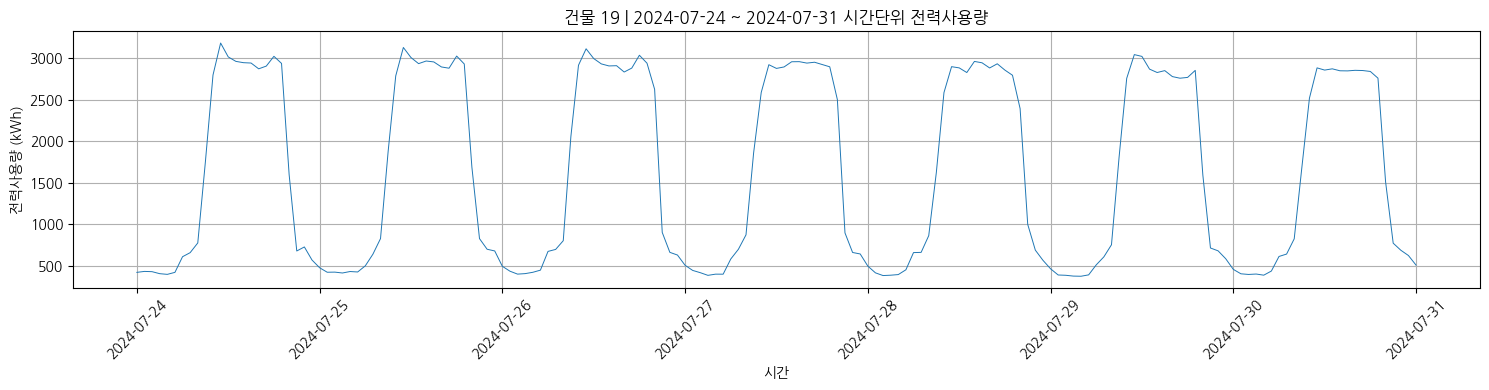

In [18]:
plot_building_power(train, building_id=19, start_date="2024-07-24", end_date="2024-07-31")


#02_EDAandPreprocessing

## 02-1. 이상값 처리

In [19]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=18, month=6, day=11,
    target_hours=17,
    ref_hour1=16, ref_hour2=19,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 18, 'month': 6, 'day': 11, 'target_hours': [17], 'ref_hour1': 16, 'ref_hour2': 19, 'new_val': 1870.08, 'rows_changed': 1, 'column': 'power_consumption'}


In [20]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=18, month=6, day=11,
    target_hours=18,
    ref_hour1=17, ref_hour2=19,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 18, 'month': 6, 'day': 11, 'target_hours': [18], 'ref_hour1': 17, 'ref_hour2': 19, 'new_val': 1802.76, 'rows_changed': 1, 'column': 'power_consumption'}


In [21]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=18, month=7, day=17,
    target_hours=14,
    ref_hour1=13, ref_hour2=15,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 18, 'month': 7, 'day': 17, 'target_hours': [14], 'ref_hour1': 13, 'ref_hour2': 15, 'new_val': 2175.7200000000003, 'rows_changed': 1, 'column': 'power_consumption'}


In [22]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=18, month=8, day=8,
    target_hours=15,
    ref_hour1=14, ref_hour2=17,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 18, 'month': 8, 'day': 8, 'target_hours': [15], 'ref_hour1': 14, 'ref_hour2': 17, 'new_val': 2117.88, 'rows_changed': 1, 'column': 'power_consumption'}


In [23]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=18, month=8, day=8,
    target_hours=15,
    ref_hour1=14, ref_hour2=17,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 18, 'month': 8, 'day': 8, 'target_hours': [15], 'ref_hour1': 14, 'ref_hour2': 17, 'new_val': 2117.88, 'rows_changed': 1, 'column': 'power_consumption'}


In [24]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=18, month=8, day=8,
    target_hours=16,
    ref_hour1=15, ref_hour2=17,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 18, 'month': 8, 'day': 8, 'target_hours': [16], 'ref_hour1': 15, 'ref_hour2': 17, 'new_val': 2081.94, 'rows_changed': 1, 'column': 'power_consumption'}


In [25]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=19, month=7, day=31,
    target_hours=13,
    ref_hour1=12, ref_hour2=17,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 19, 'month': 7, 'day': 31, 'target_hours': [13], 'ref_hour1': 12, 'ref_hour2': 17, 'new_val': 2844.1800000000003, 'rows_changed': 1, 'column': 'power_consumption'}


In [26]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=19, month=7, day=31,
    target_hours=14,
    ref_hour1=13, ref_hour2=17,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 19, 'month': 7, 'day': 31, 'target_hours': [14], 'ref_hour1': 13, 'ref_hour2': 17, 'new_val': 2814.57, 'rows_changed': 1, 'column': 'power_consumption'}


In [27]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=19, month=7, day=31,
    target_hours=range(15, 17),
    ref_hour1=13, ref_hour2=18,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 19, 'month': 7, 'day': 31, 'target_hours': [15, 16], 'ref_hour1': 13, 'ref_hour2': 18, 'new_val': 2794.41, 'rows_changed': 2, 'column': 'power_consumption'}


In [28]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=29, month=6, day=15,
    target_hours=22,
    ref_hour1=8, ref_hour2=9,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 29, 'month': 6, 'day': 15, 'target_hours': [22], 'ref_hour1': 8, 'ref_hour2': 9, 'new_val': 928.35, 'rows_changed': 1, 'column': 'power_consumption'}


In [29]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=29, month=6, day=15,
    target_hours=23,
    ref_hour1=7, ref_hour2=22,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 29, 'month': 6, 'day': 15, 'target_hours': [23], 'ref_hour1': 7, 'ref_hour2': 22, 'new_val': 795.915, 'rows_changed': 1, 'column': 'power_consumption'}


In [30]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=29, month=6, day=16,
    target_hours=0,
    ref_hour1=5, ref_hour2=6,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 29, 'month': 6, 'day': 16, 'target_hours': [0], 'ref_hour1': 5, 'ref_hour2': 6, 'new_val': 507.96, 'rows_changed': 1, 'column': 'power_consumption'}


In [31]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=29, month=6, day=27,
    target_hours=0,
    ref_hour1=6, ref_hour2=7,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 29, 'month': 6, 'day': 27, 'target_hours': [0], 'ref_hour1': 6, 'ref_hour2': 7, 'new_val': 566.55, 'rows_changed': 1, 'column': 'power_consumption'}


In [32]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=29, month=6, day=27,
    target_hours=1,
    ref_hour1=0, ref_hour2=2,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 29, 'month': 6, 'day': 27, 'target_hours': [1], 'ref_hour1': 0, 'ref_hour2': 2, 'new_val': 528.165, 'rows_changed': 1, 'column': 'power_consumption'}


In [33]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=40, month=7, day=14,
    target_hours=0,
    ref_hour1=1, ref_hour2=7,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 40, 'month': 7, 'day': 14, 'target_hours': [0], 'ref_hour1': 1, 'ref_hour2': 7, 'new_val': 482.30999999999995, 'rows_changed': 1, 'column': 'power_consumption'}


In [34]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=40, month=7, day=14,
    target_hours=1,
    ref_hour1=1, ref_hour2=2,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 40, 'month': 7, 'day': 14, 'target_hours': [1], 'ref_hour1': 1, 'ref_hour2': 2, 'new_val': 441.53999999999996, 'rows_changed': 1, 'column': 'power_consumption'}


In [35]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=73, month=7, day=8,
    target_hours=22,
    ref_hour1=21, ref_hour2=23,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 73, 'month': 7, 'day': 8, 'target_hours': [22], 'ref_hour1': 21, 'ref_hour2': 23, 'new_val': 904.56, 'rows_changed': 1, 'column': 'power_consumption'}


In [36]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=79, month=8, day=19,
    target_hours=3,
    ref_hour1=1, ref_hour2=2,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 79, 'month': 8, 'day': 19, 'target_hours': [3], 'ref_hour1': 1, 'ref_hour2': 2, 'new_val': 2085.48, 'rows_changed': 1, 'column': 'power_consumption'}


In [37]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=79, month=8, day=19,
    target_hours=4,
    ref_hour1=2, ref_hour2=3,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 79, 'month': 8, 'day': 19, 'target_hours': [4], 'ref_hour1': 2, 'ref_hour2': 3, 'new_val': 2051.82, 'rows_changed': 1, 'column': 'power_consumption'}


In [38]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=79, month=8, day=19,
    target_hours=5,
    ref_hour1=0, ref_hour2=3,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 79, 'month': 8, 'day': 19, 'target_hours': [5], 'ref_hour1': 0, 'ref_hour2': 3, 'new_val': 2187.1800000000003, 'rows_changed': 1, 'column': 'power_consumption'}


In [39]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=88, month=8, day=23,
    target_hours=8,
    ref_hour1=7, ref_hour2=9,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 88, 'month': 8, 'day': 23, 'target_hours': [8], 'ref_hour1': 7, 'ref_hour2': 9, 'new_val': 1341.84, 'rows_changed': 1, 'column': 'power_consumption'}


In [40]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=88, month=8, day=23,
    target_hours=7,
    ref_hour1=7, ref_hour2=8,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 88, 'month': 8, 'day': 23, 'target_hours': [7], 'ref_hour1': 7, 'ref_hour2': 8, 'new_val': 670.92, 'rows_changed': 1, 'column': 'power_consumption'}


In [41]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=95, month=8, day=5,
    target_hours=10,
    ref_hour1=9, ref_hour2=12,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 95, 'month': 8, 'day': 5, 'target_hours': [10], 'ref_hour1': 9, 'ref_hour2': 12, 'new_val': 724.3199999999999, 'rows_changed': 1, 'column': 'power_consumption'}


In [42]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=95, month=8, day=5,
    target_hours=11,
    ref_hour1=10, ref_hour2=12,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 95, 'month': 8, 'day': 5, 'target_hours': [11], 'ref_hour1': 10, 'ref_hour2': 12, 'new_val': 757.92, 'rows_changed': 1, 'column': 'power_consumption'}


In [43]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=9, month=6, day=12,
    target_hours=10,
    ref_hour1=10, ref_hour2=12,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 9, 'month': 6, 'day': 12, 'target_hours': [10], 'ref_hour1': 10, 'ref_hour2': 12, 'new_val': 3674.0299999999997, 'rows_changed': 1, 'column': 'power_consumption'}


In [44]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=9, month=6, day=12,
    target_hours=11,
    ref_hour1=11, ref_hour2=12,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 9, 'month': 6, 'day': 12, 'target_hours': [11], 'ref_hour1': 11, 'ref_hour2': 12, 'new_val': 3427.535, 'rows_changed': 1, 'column': 'power_consumption'}


In [45]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=77, month=7, day=17,
    target_hours=14,
    ref_hour1=12, ref_hour2=16,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 77, 'month': 7, 'day': 17, 'target_hours': [14], 'ref_hour1': 12, 'ref_hour2': 16, 'new_val': 1734.3899999999999, 'rows_changed': 1, 'column': 'power_consumption'}


In [46]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=77, month=7, day=17,
    target_hours=15,
    ref_hour1=14, ref_hour2=16,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 77, 'month': 7, 'day': 17, 'target_hours': [15], 'ref_hour1': 14, 'ref_hour2': 16, 'new_val': 1750.065, 'rows_changed': 1, 'column': 'power_consumption'}


In [47]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=77, month=8, day=6,
    target_hours=17,
    ref_hour1=7, ref_hour2=17,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 77, 'month': 8, 'day': 6, 'target_hours': [17], 'ref_hour1': 7, 'ref_hour2': 17, 'new_val': 2203.41, 'rows_changed': 1, 'column': 'power_consumption'}


In [48]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=77, month=8, day=6,
    target_hours=18,
    ref_hour1=18, ref_hour2=19,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 77, 'month': 8, 'day': 6, 'target_hours': [18], 'ref_hour1': 18, 'ref_hour2': 19, 'new_val': 2219.1000000000004, 'rows_changed': 1, 'column': 'power_consumption'}


In [49]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=77, month=8, day=20,
    target_hours=10,
    ref_hour1=10, ref_hour2=11,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 77, 'month': 8, 'day': 20, 'target_hours': [10], 'ref_hour1': 10, 'ref_hour2': 11, 'new_val': 1853.9700000000003, 'rows_changed': 1, 'column': 'power_consumption'}


In [50]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=77, month=8, day=20,
    target_hours=9,
    ref_hour1=10, ref_hour2=11,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 77, 'month': 8, 'day': 20, 'target_hours': [9], 'ref_hour1': 10, 'ref_hour2': 11, 'new_val': 1718.3250000000003, 'rows_changed': 1, 'column': 'power_consumption'}


In [51]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=77, month=8, day=21,
    target_hours=19,
    ref_hour1=21, ref_hour2=20,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 77, 'month': 8, 'day': 21, 'target_hours': [19], 'ref_hour1': 21, 'ref_hour2': 20, 'new_val': 1435.35, 'rows_changed': 1, 'column': 'power_consumption'}


In [52]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=77, month=8, day=21,
    target_hours=18,
    ref_hour1=19, ref_hour2=21,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 77, 'month': 8, 'day': 21, 'target_hours': [18], 'ref_hour1': 19, 'ref_hour2': 21, 'new_val': 1479.705, 'rows_changed': 1, 'column': 'power_consumption'}


In [53]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=77, month=8, day=21,
    target_hours=17,
    ref_hour1=16, ref_hour2=18,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 77, 'month': 8, 'day': 21, 'target_hours': [17], 'ref_hour1': 16, 'ref_hour2': 18, 'new_val': 1537.7024999999999, 'rows_changed': 1, 'column': 'power_consumption'}


In [54]:
edit_log = []
train = overwrite_day_by_md(train, building=89,
                            target_month=7, target_day=11,
                            source_month=7, source_day=7,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

{'building': 89, 'target_md': '07-11', 'source_md': '07-07', 'rows_changed': 24, 'column': 'power_consumption'}


In [55]:
edit_log = []
train = overwrite_day_by_md(train, building=89,
                            target_month=7, target_day=12,
                            source_month=7, source_day=18,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

{'building': 89, 'target_md': '07-12', 'source_md': '07-18', 'rows_changed': 24, 'column': 'power_consumption'}


In [56]:
edit_log = []
train = overwrite_day_by_md(train, building=89,
                            target_month=7, target_day=15,
                            source_month=7, source_day=8,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

{'building': 89, 'target_md': '07-15', 'source_md': '07-08', 'rows_changed': 24, 'column': 'power_consumption'}


In [57]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=89, month=8, day=20,
    target_hours=22,
    ref_hour1=14, ref_hour2=11,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 89, 'month': 8, 'day': 20, 'target_hours': [22], 'ref_hour1': 14, 'ref_hour2': 11, 'new_val': 8461.215, 'rows_changed': 1, 'column': 'power_consumption'}


In [58]:
edit_log = []
train = overwrite_day_by_md(train, building=98,
                            target_month=6, target_day=6,
                            source_month=6, source_day=2,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

{'building': 98, 'target_md': '06-06', 'source_md': '06-02', 'rows_changed': 24, 'column': 'power_consumption'}


In [59]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=98, month=6, day=13,
    target_hours=14,
    ref_hour1=11, ref_hour2=12,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 98, 'month': 6, 'day': 13, 'target_hours': [14], 'ref_hour1': 11, 'ref_hour2': 12, 'new_val': 1944.9, 'rows_changed': 1, 'column': 'power_consumption'}


In [60]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=98, month=6, day=13,
    target_hours=15,
    ref_hour1=11, ref_hour2=16,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 98, 'month': 6, 'day': 13, 'target_hours': [15], 'ref_hour1': 11, 'ref_hour2': 16, 'new_val': 2058.84, 'rows_changed': 1, 'column': 'power_consumption'}


In [61]:
edit_log = []

train = reduce_daytime_range(train, building=100, month=7, day=10,
                             start_hour=3, end_hour=21,
                             reduce_val=400,
                             col='power_consumption',
                             keep_backup=True,
                             log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 로그 확인


{'building': 100, 'month': 7, 'day': 10, 'start_hour': 3, 'end_hour': 21, 'reduce_val': 400, 'rows_changed': 19, 'column': 'power_consumption'}


In [62]:
edit_log = []

train = reduce_daytime_range(train, building=100, month=7, day=11,
                             start_hour=3, end_hour=21,
                             reduce_val=400,
                             col='power_consumption',
                             keep_backup=True,
                             log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 로그 확인


{'building': 100, 'month': 7, 'day': 11, 'start_hour': 3, 'end_hour': 21, 'reduce_val': 400, 'rows_changed': 19, 'column': 'power_consumption'}


In [63]:
edit_log = []

train = reduce_daytime_range(train, building=100, month=7, day=12,
                             start_hour=3, end_hour=21,
                             reduce_val=400,
                             col='power_consumption',
                             keep_backup=True,
                             log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 로그 확인


{'building': 100, 'month': 7, 'day': 12, 'start_hour': 3, 'end_hour': 21, 'reduce_val': 400, 'rows_changed': 19, 'column': 'power_consumption'}


In [64]:
edit_log = []

train = reduce_daytime_range(train, building=100, month=7, day=13,
                             start_hour=3, end_hour=18,
                             reduce_val=400,
                             col='power_consumption',
                             keep_backup=True,
                             log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 로그 확인


{'building': 100, 'month': 7, 'day': 13, 'start_hour': 3, 'end_hour': 18, 'reduce_val': 400, 'rows_changed': 16, 'column': 'power_consumption'}


In [65]:
edit_log = []

train = reduce_daytime_range(train, building=100, month=7, day=14,
                             start_hour=8, end_hour=20,
                             reduce_val=500,
                             col='power_consumption',
                             keep_backup=True,
                             log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 로그 확인


{'building': 100, 'month': 7, 'day': 14, 'start_hour': 8, 'end_hour': 20, 'reduce_val': 500, 'rows_changed': 13, 'column': 'power_consumption'}


In [66]:
edit_log = []
train = overwrite_day_by_md(train, building=100,
                            target_month=8, target_day=9,
                            source_month=8, source_day=6,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

{'building': 100, 'target_md': '08-09', 'source_md': '08-06', 'rows_changed': 24, 'column': 'power_consumption'}


In [67]:
edit_log = []
train = overwrite_day_by_md(train, building=100,
                            target_month=8, target_day=10,
                            source_month=8, source_day=7,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

{'building': 100, 'target_md': '08-10', 'source_md': '08-07', 'rows_changed': 24, 'column': 'power_consumption'}


In [68]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=18, month=7, day=17,
    target_hours=range(13, 15),
    ref_hour1=9, ref_hour2=15,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 18, 'month': 7, 'day': 17, 'target_hours': [13, 14], 'ref_hour1': 9, 'ref_hour2': 15, 'new_val': 1972.0800000000002, 'rows_changed': 2, 'column': 'power_consumption'}


In [69]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=20, month=6, day=1,
    target_hours=10,
    ref_hour1=9, ref_hour2=12,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 20, 'month': 6, 'day': 1, 'target_hours': [10], 'ref_hour1': 9, 'ref_hour2': 12, 'new_val': 1692.3600000000001, 'rows_changed': 1, 'column': 'power_consumption'}


In [70]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=20, month=6, day=1,
    target_hours=11,
    ref_hour1=10, ref_hour2=12,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 20, 'month': 6, 'day': 1, 'target_hours': [11], 'ref_hour1': 10, 'ref_hour2': 12, 'new_val': 1697.94, 'rows_changed': 1, 'column': 'power_consumption'}


In [71]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=41, month=6, day=22,
    target_hours=1,
    ref_hour1=0, ref_hour2=5,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 41, 'month': 6, 'day': 22, 'target_hours': [1], 'ref_hour1': 0, 'ref_hour2': 5, 'new_val': 2707.38, 'rows_changed': 1, 'column': 'power_consumption'}


In [72]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=41, month=6, day=22,
    target_hours=2,
    ref_hour1=0, ref_hour2=6,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 41, 'month': 6, 'day': 22, 'target_hours': [2], 'ref_hour1': 0, 'ref_hour2': 6, 'new_val': 2706.66, 'rows_changed': 1, 'column': 'power_consumption'}


In [73]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=41, month=6, day=22,
    target_hours=3,
    ref_hour1=0, ref_hour2=7,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 41, 'month': 6, 'day': 22, 'target_hours': [3], 'ref_hour1': 0, 'ref_hour2': 7, 'new_val': 2709.99, 'rows_changed': 1, 'column': 'power_consumption'}


In [74]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=41, month=6, day=22,
    target_hours=4,
    ref_hour1=0, ref_hour2=8,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 41, 'month': 6, 'day': 22, 'target_hours': [4], 'ref_hour1': 0, 'ref_hour2': 8, 'new_val': 2714.13, 'rows_changed': 1, 'column': 'power_consumption'}


In [75]:
edit_log = []
train = overwrite_day_by_md(train, building=41,
                            target_month=7, target_day=17,
                            source_month=7, source_day=14,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

{'building': 41, 'target_md': '07-17', 'source_md': '07-14', 'rows_changed': 24, 'column': 'power_consumption'}


In [76]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=51, month=6, day=10,
    target_hours=17,
    ref_hour1=16, ref_hour2=18,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 51, 'month': 6, 'day': 10, 'target_hours': [17], 'ref_hour1': 16, 'ref_hour2': 18, 'new_val': 3349.92, 'rows_changed': 1, 'column': 'power_consumption'}


In [77]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=51, month=6, day=24,
    target_hours=17,
    ref_hour1=16, ref_hour2=18,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 51, 'month': 6, 'day': 24, 'target_hours': [17], 'ref_hour1': 16, 'ref_hour2': 18, 'new_val': 3306.96, 'rows_changed': 1, 'column': 'power_consumption'}


In [78]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=51, month=7, day=15,
    target_hours=17,
    ref_hour1=16, ref_hour2=18,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 51, 'month': 7, 'day': 15, 'target_hours': [17], 'ref_hour1': 16, 'ref_hour2': 18, 'new_val': 3437.76, 'rows_changed': 1, 'column': 'power_consumption'}


In [79]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=51, month=7, day=29,
    target_hours=17,
    ref_hour1=16, ref_hour2=18,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 51, 'month': 7, 'day': 29, 'target_hours': [17], 'ref_hour1': 16, 'ref_hour2': 18, 'new_val': 3504.0, 'rows_changed': 1, 'column': 'power_consumption'}


In [80]:
edit_log = []

train = reduce_daytime_range(train, building=99, month=7, day=3,
                             start_hour=5, end_hour=7,
                             reduce_val=300,
                             col='power_consumption',
                             keep_backup=True,
                             log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 로그 확인


{'building': 99, 'month': 7, 'day': 3, 'start_hour': 5, 'end_hour': 7, 'reduce_val': 300, 'rows_changed': 3, 'column': 'power_consumption'}


In [81]:
edit_log = []

train = increase_daytime_range(train, building=99, month=7, day=10,
                             start_hour=5, end_hour=7,
                             increase_val=150,
                             col='power_consumption',
                             keep_backup=True,
                             log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 로그 확인


{'building': 99, 'month': 7, 'day': 10, 'start_hour': 5, 'end_hour': 7, 'increase_val': 150, 'rows_changed': 3, 'column': 'power_consumption'}


In [82]:
edit_log = []

train = reduce_daytime_range(train, building=99, month=8, day=7,
                             start_hour=5, end_hour=7,
                             reduce_val=400,
                             col='power_consumption',
                             keep_backup=True,
                             log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 로그 확인


{'building': 99, 'month': 8, 'day': 7, 'start_hour': 5, 'end_hour': 7, 'reduce_val': 400, 'rows_changed': 3, 'column': 'power_consumption'}


In [83]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=5, month=8, day=4,
    target_hours=7,
    ref_hour1=6, ref_hour2=9,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 5, 'month': 8, 'day': 4, 'target_hours': [7], 'ref_hour1': 6, 'ref_hour2': 9, 'new_val': 3754.08, 'rows_changed': 1, 'column': 'power_consumption'}


In [84]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=5, month=8, day=4,
    target_hours=8,
    ref_hour1=7, ref_hour2=9,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 5, 'month': 8, 'day': 4, 'target_hours': [8], 'ref_hour1': 7, 'ref_hour2': 9, 'new_val': 3847.2, 'rows_changed': 1, 'column': 'power_consumption'}


In [85]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=8, month=7, day=21,
    target_hours=8,
    ref_hour1=8, ref_hour2=14,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 8, 'month': 7, 'day': 21, 'target_hours': [8], 'ref_hour1': 8, 'ref_hour2': 14, 'new_val': 418.2, 'rows_changed': 1, 'column': 'power_consumption'}


In [86]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=8, month=7, day=21,
    target_hours=9,
    ref_hour1=8, ref_hour2=14,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 8, 'month': 7, 'day': 21, 'target_hours': [9], 'ref_hour1': 8, 'ref_hour2': 14, 'new_val': 494.54999999999995, 'rows_changed': 1, 'column': 'power_consumption'}


In [87]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=8, month=7, day=21,
    target_hours=10,
    ref_hour1=8, ref_hour2=15,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 8, 'month': 7, 'day': 21, 'target_hours': [10], 'ref_hour1': 8, 'ref_hour2': 15, 'new_val': 474.29999999999995, 'rows_changed': 1, 'column': 'power_consumption'}


In [88]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=8, month=7, day=21,
    target_hours=11,
    ref_hour1=10, ref_hour2=15,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 8, 'month': 7, 'day': 21, 'target_hours': [11], 'ref_hour1': 10, 'ref_hour2': 15, 'new_val': 502.34999999999997, 'rows_changed': 1, 'column': 'power_consumption'}


In [89]:
edit_log = []
train = overwrite_day_by_md(train, building=8,
                            target_month=8, target_day=24,
                            source_month=8, source_day=10,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

{'building': 8, 'target_md': '08-24', 'source_md': '08-10', 'rows_changed': 24, 'column': 'power_consumption'}


In [90]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=12, month=7, day=17,
    target_hours=14,
    ref_hour1=13, ref_hour2=15,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 12, 'month': 7, 'day': 17, 'target_hours': [14], 'ref_hour1': 13, 'ref_hour2': 15, 'new_val': 8405.279999999999, 'rows_changed': 1, 'column': 'power_consumption'}


In [91]:
edit_log = []

train = increase_daytime_range(train, building=12, month=7, day=21,
                             start_hour=8, end_hour=11,
                             increase_val=1500,
                             col='power_consumption',
                             keep_backup=True,
                             log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 로그 확인


{'building': 12, 'month': 7, 'day': 21, 'start_hour': 8, 'end_hour': 11, 'increase_val': 1500, 'rows_changed': 4, 'column': 'power_consumption'}


In [92]:
edit_log = []

train = increase_daytime_range(train, building=12, month=7, day=21,
                             start_hour=9, end_hour=11,
                             increase_val=400,
                             col='power_consumption',
                             keep_backup=True,
                             log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 로그 확인


{'building': 12, 'month': 7, 'day': 21, 'start_hour': 9, 'end_hour': 11, 'increase_val': 400, 'rows_changed': 3, 'column': 'power_consumption'}


In [93]:
edit_log = []
train = overwrite_day_by_md(train, building=12,
                            target_month=8, target_day=24,
                            source_month=8, source_day=17,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

{'building': 12, 'target_md': '08-24', 'source_md': '08-17', 'rows_changed': 24, 'column': 'power_consumption'}


In [94]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=24, month=7, day=17,
    target_hours=14,
    ref_hour1=13, ref_hour2=15,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 24, 'month': 7, 'day': 17, 'target_hours': [14], 'ref_hour1': 13, 'ref_hour2': 15, 'new_val': 1800.885, 'rows_changed': 1, 'column': 'power_consumption'}


In [95]:
edit_log = []
train = overwrite_day_by_md(train, building=24,
                            target_month=7, target_day=20,
                            source_month=7, source_day=13,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

{'building': 24, 'target_md': '07-20', 'source_md': '07-13', 'rows_changed': 24, 'column': 'power_consumption'}


In [96]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=46, month=7, day=17,
    target_hours=14,
    ref_hour1=13, ref_hour2=15,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 46, 'month': 7, 'day': 17, 'target_hours': [14], 'ref_hour1': 13, 'ref_hour2': 15, 'new_val': 1469.76, 'rows_changed': 1, 'column': 'power_consumption'}


In [97]:
edit_log = []
train = overwrite_day_by_md(train, building=46,
                            target_month=8, target_day=17,
                            source_month=8, source_day=10,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

{'building': 46, 'target_md': '08-17', 'source_md': '08-10', 'rows_changed': 24, 'column': 'power_consumption'}


In [98]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=55, month=7, day=17,
    target_hours=14,
    ref_hour1=13, ref_hour2=15,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 55, 'month': 7, 'day': 17, 'target_hours': [14], 'ref_hour1': 13, 'ref_hour2': 15, 'new_val': 10129.68, 'rows_changed': 1, 'column': 'power_consumption'}


In [99]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=60, month=7, day=17,
    target_hours=13,
    ref_hour1=12, ref_hour2=16,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 60, 'month': 7, 'day': 17, 'target_hours': [13], 'ref_hour1': 12, 'ref_hour2': 16, 'new_val': 5131.620000000001, 'rows_changed': 1, 'column': 'power_consumption'}


In [100]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=60, month=7, day=17,
    target_hours=14,
    ref_hour1=13, ref_hour2=16,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 60, 'month': 7, 'day': 17, 'target_hours': [14], 'ref_hour1': 13, 'ref_hour2': 16, 'new_val': 5096.610000000001, 'rows_changed': 1, 'column': 'power_consumption'}


In [101]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=60, month=7, day=17,
    target_hours=15,
    ref_hour1=14, ref_hour2=16,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 60, 'month': 7, 'day': 17, 'target_hours': [15], 'ref_hour1': 14, 'ref_hour2': 16, 'new_val': 5079.1050000000005, 'rows_changed': 1, 'column': 'power_consumption'}


In [102]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=47, month=7, day=17,
    target_hours=14,
    ref_hour1=13, ref_hour2=15,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 47, 'month': 7, 'day': 17, 'target_hours': [14], 'ref_hour1': 13, 'ref_hour2': 15, 'new_val': 1728.18, 'rows_changed': 1, 'column': 'power_consumption'}


In [103]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=69, month=7, day=17,
    target_hours=14,
    ref_hour1=13, ref_hour2=16,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 69, 'month': 7, 'day': 17, 'target_hours': [14], 'ref_hour1': 13, 'ref_hour2': 16, 'new_val': 9772.59, 'rows_changed': 1, 'column': 'power_consumption'}


In [104]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=69, month=7, day=17,
    target_hours=15,
    ref_hour1=14, ref_hour2=16,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 69, 'month': 7, 'day': 17, 'target_hours': [15], 'ref_hour1': 14, 'ref_hour2': 16, 'new_val': 9826.83, 'rows_changed': 1, 'column': 'power_consumption'}


In [105]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=78, month=7, day=17,
    target_hours=14,
    ref_hour1=13, ref_hour2=16,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 78, 'month': 7, 'day': 17, 'target_hours': [14], 'ref_hour1': 13, 'ref_hour2': 16, 'new_val': 1408.5, 'rows_changed': 1, 'column': 'power_consumption'}


In [106]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=82, month=7, day=17,
    target_hours=14,
    ref_hour1=13, ref_hour2=16,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 82, 'month': 7, 'day': 17, 'target_hours': [14], 'ref_hour1': 13, 'ref_hour2': 16, 'new_val': 1843.56, 'rows_changed': 1, 'column': 'power_consumption'}


In [107]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=97, month=7, day=17,
    target_hours=14,
    ref_hour1=13, ref_hour2=16,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 97, 'month': 7, 'day': 17, 'target_hours': [14], 'ref_hour1': 13, 'ref_hour2': 16, 'new_val': 1576.44, 'rows_changed': 1, 'column': 'power_consumption'}


In [108]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=3, month=7, day=17,
    target_hours=14,
    ref_hour1=13, ref_hour2=16,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 3, 'month': 7, 'day': 17, 'target_hours': [14], 'ref_hour1': 13, 'ref_hour2': 16, 'new_val': 24283.74, 'rows_changed': 1, 'column': 'power_consumption'}


In [109]:
edit_log = []
train = overwrite_day_by_md(train, building=17,
                            target_month=6, target_day=25,
                            source_month=6, source_day=18,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

{'building': 17, 'target_md': '06-25', 'source_md': '06-18', 'rows_changed': 24, 'column': 'power_consumption'}


In [110]:
edit_log = []
train = overwrite_day_by_md(train, building=17,
                            target_month=6, target_day=26,
                            source_month=6, source_day=19,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

{'building': 17, 'target_md': '06-26', 'source_md': '06-19', 'rows_changed': 24, 'column': 'power_consumption'}


In [111]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=42, month=7, day=17,
    target_hours=14,
    ref_hour1=13, ref_hour2=16,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 42, 'month': 7, 'day': 17, 'target_hours': [14], 'ref_hour1': 13, 'ref_hour2': 16, 'new_val': 5536.4400000000005, 'rows_changed': 1, 'column': 'power_consumption'}


In [112]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=44, month=6, day=6,
    target_hours=13,
    ref_hour1=12, ref_hour2=15,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 44, 'month': 6, 'day': 6, 'target_hours': [13], 'ref_hour1': 12, 'ref_hour2': 15, 'new_val': 1160.16, 'rows_changed': 1, 'column': 'power_consumption'}


In [113]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=44, month=6, day=6,
    target_hours=14,
    ref_hour1=13, ref_hour2=15,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 44, 'month': 6, 'day': 6, 'target_hours': [14], 'ref_hour1': 13, 'ref_hour2': 15, 'new_val': 1187.16, 'rows_changed': 1, 'column': 'power_consumption'}


In [114]:
edit_log = []
train = overwrite_day_by_md(train, building=44,
                            target_month=6, target_day=29,
                            source_month=6, source_day=22,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

{'building': 44, 'target_md': '06-29', 'source_md': '06-22', 'rows_changed': 24, 'column': 'power_consumption'}


In [115]:
edit_log = []
train = overwrite_day_by_md(train, building=44,
                            target_month=6, target_day=30,
                            source_month=6, source_day=23,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

{'building': 44, 'target_md': '06-30', 'source_md': '06-23', 'rows_changed': 24, 'column': 'power_consumption'}


In [116]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=90, month=6, day=5,
    target_hours=17,
    ref_hour1=16, ref_hour2=19,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 90, 'month': 6, 'day': 5, 'target_hours': [17], 'ref_hour1': 16, 'ref_hour2': 19, 'new_val': 2093.1, 'rows_changed': 1, 'column': 'power_consumption'}


In [117]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=90, month=6, day=5,
    target_hours=18,
    ref_hour1=17, ref_hour2=19,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 90, 'month': 6, 'day': 5, 'target_hours': [18], 'ref_hour1': 17, 'ref_hour2': 19, 'new_val': 1942.65, 'rows_changed': 1, 'column': 'power_consumption'}


In [118]:
edit_log = []
train = overwrite_day_by_md(train, building=25,
                            target_month=7, target_day=4,
                            source_month=6, source_day=27,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

{'building': 25, 'target_md': '07-04', 'source_md': '06-27', 'rows_changed': 24, 'column': 'power_consumption'}


In [119]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=31, month=7, day=17,
    target_hours=14,
    ref_hour1=13, ref_hour2=15,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 31, 'month': 7, 'day': 17, 'target_hours': [14], 'ref_hour1': 13, 'ref_hour2': 15, 'new_val': 827.4000000000001, 'rows_changed': 1, 'column': 'power_consumption'}


In [120]:
edit_log = []
train = overwrite_day_by_md(train, building=70,
                            target_month=6, target_day=4,
                            source_month=6, source_day=11,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

{'building': 70, 'target_md': '06-04', 'source_md': '06-11', 'rows_changed': 24, 'column': 'power_consumption'}


In [121]:
edit_log = []
train = overwrite_day_by_md(train, building=70,
                            target_month=6, target_day=5,
                            source_month=6, source_day=12,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

{'building': 70, 'target_md': '06-05', 'source_md': '06-12', 'rows_changed': 24, 'column': 'power_consumption'}


In [122]:
edit_log = []
train = overwrite_day_by_md(train, building=94,
                            target_month=7, target_day=27,
                            source_month=7, source_day=20,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

{'building': 94, 'target_md': '07-27', 'source_md': '07-20', 'rows_changed': 24, 'column': 'power_consumption'}


In [123]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=30, month=7, day=13,
    target_hours=20,
    ref_hour1=19, ref_hour2=21,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 30, 'month': 7, 'day': 13, 'target_hours': [20], 'ref_hour1': 19, 'ref_hour2': 21, 'new_val': 9819.720000000001, 'rows_changed': 1, 'column': 'power_consumption'}


In [124]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=30, month=7, day=25,
    target_hours=0,
    ref_hour1=1, ref_hour2=2,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 30, 'month': 7, 'day': 25, 'target_hours': [0], 'ref_hour1': 1, 'ref_hour2': 2, 'new_val': 9811.080000000002, 'rows_changed': 1, 'column': 'power_consumption'}


In [125]:
edit_log = []
train = overwrite_day_by_md(train, building=43,
                            target_month=6, target_day=10,
                            source_month=6, source_day=3,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

{'building': 43, 'target_md': '06-10', 'source_md': '06-03', 'rows_changed': 24, 'column': 'power_consumption'}


In [126]:
edit_log = []
train = overwrite_day_by_md(train, building=43,
                            target_month=8, target_day=12,
                            source_month=8, source_day=5,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

{'building': 43, 'target_md': '08-12', 'source_md': '08-05', 'rows_changed': 24, 'column': 'power_consumption'}


In [127]:
edit_log = []
train = overwrite_day_by_md(train, building=52,
                            target_month=8, target_day=10,
                            source_month=8, source_day=3,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

{'building': 52, 'target_md': '08-10', 'source_md': '08-03', 'rows_changed': 24, 'column': 'power_consumption'}


In [128]:
edit_log = []
train = overwrite_day_by_md(train, building=67,
                            target_month=6, target_day=10,
                            source_month=6, source_day=3,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

{'building': 67, 'target_md': '06-10', 'source_md': '06-03', 'rows_changed': 24, 'column': 'power_consumption'}


In [129]:
edit_log = []
train = overwrite_day_by_md(train, building=67,
                            target_month=8, target_day=12,
                            source_month=8, source_day=5,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

{'building': 67, 'target_md': '08-12', 'source_md': '08-05', 'rows_changed': 24, 'column': 'power_consumption'}


In [130]:
edit_log = []
train = overwrite_day_by_md(train, building=67,
                            target_month=7, target_day=26,
                            source_month=7, source_day=19,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

{'building': 67, 'target_md': '07-26', 'source_md': '07-19', 'rows_changed': 24, 'column': 'power_consumption'}


In [131]:
edit_log = []
train = overwrite_day_by_md(train, building=67,
                            target_month=7, target_day=27,
                            source_month=7, source_day=20,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

{'building': 67, 'target_md': '07-27', 'source_md': '07-20', 'rows_changed': 24, 'column': 'power_consumption'}


In [132]:
train = train[~((train['building_num'] == 57) & (train['date_time'] < "2024-06-07"))]


In [133]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=81, month=7, day=17,
    target_hours=14,
    ref_hour1=13, ref_hour2=15,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 81, 'month': 7, 'day': 17, 'target_hours': [14], 'ref_hour1': 13, 'ref_hour2': 15, 'new_val': 1308.7199999999998, 'rows_changed': 1, 'column': 'power_consumption'}


In [134]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=38, month=7, day=17,
    target_hours=14,
    ref_hour1=13, ref_hour2=16,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 38, 'month': 7, 'day': 17, 'target_hours': [14], 'ref_hour1': 13, 'ref_hour2': 16, 'new_val': 1656.54, 'rows_changed': 1, 'column': 'power_consumption'}


In [135]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=38, month=7, day=17,
    target_hours=15,
    ref_hour1=14, ref_hour2=16,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


{'building': 38, 'month': 7, 'day': 17, 'target_hours': [15], 'ref_hour1': 14, 'ref_hour2': 16, 'new_val': 1648.53, 'rows_changed': 1, 'column': 'power_consumption'}


In [136]:
edit_log = []
train = overwrite_day_by_md(train, building=68,
                            target_month=6, target_day=28,
                            source_month=6, source_day=21,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

{'building': 68, 'target_md': '06-28', 'source_md': '06-21', 'rows_changed': 24, 'column': 'power_consumption'}


In [137]:
edit_log = []
train = overwrite_day_by_md(train, building=68,
                            target_month=6, target_day=29,
                            source_month=6, source_day=22,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

{'building': 68, 'target_md': '06-29', 'source_md': '06-22', 'rows_changed': 24, 'column': 'power_consumption'}


In [138]:
edit_log = []
train = overwrite_day_by_md(train, building=72,
                            target_month=7, target_day=21,
                            source_month=7, source_day=14,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

{'building': 72, 'target_md': '07-21', 'source_md': '07-14', 'rows_changed': 24, 'column': 'power_consumption'}


In [139]:
edit_log = []
train = overwrite_day_by_md(train, building=80,
                            target_month=7, target_day=6,
                            source_month=6, source_day=29,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

{'building': 80, 'target_md': '07-06', 'source_md': '06-29', 'rows_changed': 24, 'column': 'power_consumption'}


In [140]:
edit_log = []
train = overwrite_day_by_md(train, building=80,
                            target_month=7, target_day=8,
                            source_month=7, source_day=1,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

{'building': 80, 'target_md': '07-08', 'source_md': '07-01', 'rows_changed': 24, 'column': 'power_consumption'}


In [141]:
edit_log = []
train = overwrite_day_by_md(train, building=80,
                            target_month=7, target_day=20,
                            source_month=7, source_day=13,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

{'building': 80, 'target_md': '07-20', 'source_md': '07-13', 'rows_changed': 24, 'column': 'power_consumption'}


In [142]:
edit_log = []
train = overwrite_day_by_md(train, building=92,
                            target_month=7, target_day=17,
                            source_month=7, source_day=10,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

{'building': 92, 'target_md': '07-17', 'source_md': '07-10', 'rows_changed': 24, 'column': 'power_consumption'}


In [143]:
edit_log = []
train = overwrite_day_by_md(train, building=53,
                            target_month=6, target_day=15,
                            source_month=6, source_day=16,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

{'building': 53, 'target_md': '06-15', 'source_md': '06-16', 'rows_changed': 24, 'column': 'power_consumption'}


In [144]:
edit_log = []
train = overwrite_day_by_md(train, building=76,
                            target_month=6, target_day=3,
                            source_month=6, source_day=4,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

{'building': 76, 'target_md': '06-03', 'source_md': '06-04', 'rows_changed': 24, 'column': 'power_consumption'}


In [145]:
edit_log = []
train = overwrite_day_by_md(train, building=76,
                            target_month=6, target_day=20,
                            source_month=6, source_day=13,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

{'building': 76, 'target_md': '06-20', 'source_md': '06-13', 'rows_changed': 24, 'column': 'power_consumption'}


In [146]:
outlier_idx = train.index[train['power_consumption'] == 0].tolist()
print("제거할 행 개수:", len(outlier_idx))
print("인덱스 예시:", outlier_idx[:10])

# 2) 해당 인덱스들 드롭
train.drop(index=outlier_idx, inplace=True)

# 3) 드롭 후 확인
print("남은 행 개수:", train.shape[0])

제거할 행 개수: 0
인덱스 예시: []
남은 행 개수: 203856


## 02-2. 냉방도일, 불쾌지수, 체감온도 및 풍냉지수 추가

In [147]:

# --- CDH ---
def add_cdh(df, base=26, window=24, out_col='CDH'):

    df = df.copy()
    df = df.sort_values(['building_num', 'date_time'])

    pos = (df['temperature'] - base).clip(lower=0)
    df[out_col] = (
        pos.groupby(df['building_num'])
           .transform(lambda s: s.rolling(window, min_periods=1).sum())
    )

    return df

train = add_cdh(train, base=26, window=24, out_col='CDH')
test  = add_cdh(test,  base=26, window=24, out_col='CDH')

# --- THI (°C 버전) ---
def THI_celsius(T, RH):
    RHf = RH / 100.0
    return T - 0.55*(1 - RHf)*(T - 14.5)

train['THI'] = THI_celsius(train['temperature'], train['humidity'])
test['THI']  = THI_celsius(test['temperature'],  test['humidity'])

# --- WCT (m/s -> km/h 변환 + 계수 수정) ---
def WCT_celsius(T, v_ms):
    v = v_ms * 3.6
    return 13.12 + 0.6215*T - 11.37*(v**0.16) + 0.3965*T*(v**0.16)

train['WCT'] = WCT_celsius(train['temperature'], train['windspeed'])
test['WCT']  = WCT_celsius(test['temperature'],  test['windspeed'])


## 02-3. train에만 있는 일조 및 일사 컬럼 삭제

In [148]:
train = train.drop(columns=['sunshine', 'solar_radiation'], errors='ignore')

## 02-4. 하루당 초고, 최저, 평균, 일교차 온도 추가

In [149]:
def add_daily_temp_features(df):
    grp = df.groupby(['building_num','month','day'])['temperature']
    df['day_max_temperature']  = grp.transform('max')
    df['day_mean_temperature'] = grp.transform('mean')
    df['day_min_temperature']  = grp.transform('min')
    df['day_temperature_range'] = df['day_max_temperature'] - df['day_min_temperature']
    return df

train = add_daily_temp_features(train)
test  = add_daily_temp_features(test)

## 02-5. 날짜 주기성 컬럼 추가

In [150]:
def add_cyclical_time_feats(df):

    # Day of year (계절성 표현에 유리)
    df['doy'] = df['date_time'].dt.dayofyear  # 1~366

    # 1) 시간(24시간 주기)
    df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24.0)
    df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24.0)

    # 2) 요일(7일 주기)
    df['sin_dayofweek'] = np.sin(2 * np.pi * df['day_of_week'] / 7.0)
    df['cos_dayofweek'] = np.cos(2 * np.pi * df['day_of_week'] / 7.0)

    # 3) 연중 일자(DOY, 365/366 주기) — 추천
    df['sin_doy'] = np.sin(2 * np.pi * df['doy'] / 366.0)
    df['cos_doy'] = np.cos(2 * np.pi * df['doy'] / 366.0)

    # 4) 월(12개월 주기) — 필요 시 추가 (DOY로 충분하면 생략 가능)
    df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12.0)
    df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12.0)

    return df

train = add_cyclical_time_feats(train)
test  = add_cyclical_time_feats(test)

## 02-6. 공휴일 및 주말 여부 추가

In [151]:
import holidays  # pip install holidays

# 한국 공휴일 캘린더 (2024년 기준, 대회 train/test 기간은 2024-06 ~ 2024-08)
kr_holidays = holidays.KR(years=[2024])

def add_holiday_weekend_features(df):
    # 주말 여부 (토:5, 일:6)
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

    # 공휴일 여부 (date_time에서 날짜만 비교)
    df['is_holiday'] = df['date_time'].dt.date.isin(kr_holidays).astype(int)

    return df

train = add_holiday_weekend_features(train)
test  = add_holiday_weekend_features(test)

In [152]:
train

,building_num,date_time,temperature,rainfall,windspeed,humidity,power_consumption,building_type,total_area,cooling_area,solar_power_include,ess_include,hour,day,month,day_of_week,CDH,THI,WCT,day_max_temperature,day_mean_temperature,day_min_temperature,day_temperature_range,doy,sin_hour,cos_hour,sin_dayofweek,cos_dayofweek,sin_doy,cos_doy,sin_month,cos_month,is_weekend,is_holiday
0,1,2024-06-01 00:00:00,18.3,0.0,2.6,82.0,5794.80,Hotel,82912.71,77586.0,0,0,0,1,6,5,0.0,17.92380,18.609436,24.8,20.570833,17.6,7.2,153,0.000000,1.000000,-0.974928,-0.222521,0.492548,-0.870285,1.224647e-16,-1.0,1,0
1,1,2024-06-01 01:00:00,18.3,0.0,2.7,82.0,5591.85,Hotel,82912.71,77586.0,0,0,1,1,6,5,0.0,17.92380,18.573798,24.8,20.570833,17.6,7.2,153,0.258819,0.965926,-0.974928,-0.222521,0.492548,-0.870285,1.224647e-16,-1.0,1,0
2,1,2024-06-01 02:00:00,18.1,0.0,2.6,80.0,5338.17,Hotel,82912.71,77586.0,0,0,2,1,6,5,0.0,17.70400,18.371719,24.8,20.570833,17.6,7.2,153,0.500000,0.866025,-0.974928,-0.222521,0.492548,-0.870285,1.224647e-16,-1.0,1,0
3,1,2024-06-01 03:00:00,18.0,0.0,2.6,81.0,4554.42,Hotel,82912.71,77586.0,0,0,3,1,6,5,0.0,17.63425,18.252861,24.8,20.570833,17.6,7.2,153,0.707107,0.707107,-0.974928,-0.222521,0.492548,-0.870285,1.224647e-16,-1.0,1,0
4,1,2024-06-01 04:00:00,17.8,0.0,1.3,81.0,3602.25,Hotel,82912.71,77586.0,0,0,4,1,6,5,0.0,17.45515,18.662583,24.8,20.570833,17.6,7.2,153,0.866025,0.500000,-0.974928,-0.222521,0.492548,-0.870285,1.224647e-16,-1.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100,2024-08-24 19:00:00,29.1,0.0,4.4,76.0,3276.00,Hotel,162070.24,152943.0,0,0,19,24,8,5,82.9,27.17280,31.467262,32.9,29.454167,26.8,6.1,237,-0.965926,0.258819,-0.974928,-0.222521,-0.799839,-0.600214,-8.660254e-01,-0.5,1,0
203996,100,2024-08-24 20:00:00,28.6,0.0,3.7,74.0,3197.52,Hotel,162070.24,152943.0,0,0,20,24,8,5,82.9,26.58370,30.849350,32.9,29.454167,26.8,6.1,237,-0.866025,0.500000,-0.974928,-0.222521,-0.799839,-0.600214,-8.660254e-01,-0.5,1,0
203997,100,2024-08-24 21:00:00,28.3,0.0,2.9,74.0,3006.60,Hotel,162070.24,152943.0,0,0,21,24,8,5,83.1,26.32660,30.491518,32.9,29.454167,26.8,6.1,237,-0.707107,0.707107,-0.974928,-0.222521,-0.799839,-0.600214,-8.660254e-01,-0.5,1,0
203998,100,2024-08-24 22:00:00,28.0,0.0,1.7,76.0,2649.72,Hotel,162070.24,152943.0,0,0,22,24,8,5,83.1,26.21800,30.163891,32.9,29.454167,26.8,6.1,237,-0.500000,0.866025,-0.974928,-0.222521,-0.799839,-0.600214,-8.660254e-01,-0.5,1,0


In [153]:
test

,building_num,date_time,temperature,rainfall,windspeed,humidity,building_type,total_area,cooling_area,solar_power_include,ess_include,hour,day,month,day_of_week,CDH,THI,WCT,day_max_temperature,day_mean_temperature,day_min_temperature,day_temperature_range,doy,sin_hour,cos_hour,sin_dayofweek,cos_dayofweek,sin_doy,cos_doy,sin_month,cos_month,is_weekend,is_holiday
0,1,2024-08-25 00:00:00,26.5,0.0,0.7,80.0,Hotel,82912.71,77586.0,0,0,0,25,8,6,0.5,25.1800,28.589499,32.6,28.408333,25.0,7.6,238,0.000000,1.000000,-0.781831,0.623490,-0.810025,-0.586396,-0.866025,-0.5,1,0
1,1,2024-08-25 01:00:00,26.1,0.0,0.0,80.0,Hotel,82912.71,77586.0,0,0,1,25,8,6,0.6,24.8240,29.341150,32.6,28.408333,25.0,7.6,238,0.258819,0.965926,-0.781831,0.623490,-0.810025,-0.586396,-0.866025,-0.5,1,0
2,1,2024-08-25 02:00:00,25.9,0.0,0.3,83.0,Hotel,82912.71,77586.0,0,0,2,25,8,6,0.6,24.8341,28.102563,32.6,28.408333,25.0,7.6,238,0.500000,0.866025,-0.781831,0.623490,-0.810025,-0.586396,-0.866025,-0.5,1,0
3,1,2024-08-25 03:00:00,25.7,0.0,1.1,83.0,Hotel,82912.71,77586.0,0,0,3,25,8,6,0.6,24.6528,27.621949,32.6,28.408333,25.0,7.6,238,0.707107,0.707107,-0.781831,0.623490,-0.810025,-0.586396,-0.866025,-0.5,1,0
4,1,2024-08-25 04:00:00,25.5,0.0,1.0,86.0,Hotel,82912.71,77586.0,0,0,4,25,8,6,0.6,24.6530,27.422567,32.6,28.408333,25.0,7.6,238,0.866025,0.500000,-0.781831,0.623490,-0.810025,-0.586396,-0.866025,-0.5,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16795,100,2024-08-31 19:00:00,27.1,0.0,2.7,68.0,Hotel,162070.24,152943.0,0,0,19,31,8,5,56.5,24.8824,29.063562,31.5,27.970833,25.5,6.0,244,-0.965926,0.258819,-0.974928,-0.222521,-0.866025,-0.500000,-0.866025,-0.5,1,0
16796,100,2024-08-31 20:00:00,26.5,0.0,2.9,73.0,Hotel,162070.24,152943.0,0,0,20,31,8,5,54.2,24.7180,28.334076,31.5,27.970833,25.5,6.0,244,-0.866025,0.500000,-0.974928,-0.222521,-0.866025,-0.500000,-0.866025,-0.5,1,0
16797,100,2024-08-31 21:00:00,26.3,0.0,3.5,73.0,Hotel,162070.24,152943.0,0,0,21,31,8,5,52.0,24.5477,28.052479,31.5,27.970833,25.5,6.0,244,-0.707107,0.707107,-0.974928,-0.222521,-0.866025,-0.500000,-0.866025,-0.5,1,0
16798,100,2024-08-31 22:00:00,26.0,0.0,3.4,68.0,Hotel,162070.24,152943.0,0,0,22,31,8,5,49.8,23.9760,27.694981,31.5,27.970833,25.5,6.0,244,-0.500000,0.866025,-0.974928,-0.222521,-0.866025,-0.500000,-0.866025,-0.5,1,0


In [154]:
X = train.drop(['power_consumption','hour','day','month','day_of_week','date_time'],axis =1 )

Y = train['power_consumption']

test_X = test.drop(['hour','month','day_of_week','day','date_time'], axis=1)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
X['building_num'] = le.fit_transform(X['building_num'])
test_X['building_num'] = le.transform(test_X['building_num'])


In [155]:
print("📌 Library Versions")
print(f"matplotlib : {matplotlib.__version__}")
print(f"pandas     : {pd.__version__}")
print(f"seaborn    : {sns.__version__}")
print(f"numpy      : {np.__version__}")
print(f"scikit-learn : {sklearn.__version__}")
print(f"xgboost    : {xgboost.__version__}")
print(f"random     : built-in (no version)")   # 파이썬 내장 라이브러리
print(f"datetime   : built-in (no version)")
print(f"warnings   : built-in (no version)")

📌 Library Versions
matplotlib : 3.10.0
pandas     : 2.2.2
seaborn    : 0.13.2
numpy      : 2.0.2
scikit-learn : 1.6.1
xgboost    : 3.0.4
random     : built-in (no version)
datetime   : built-in (no version)
warnings   : built-in (no version)



===== Building Type: Hotel =====
  Fold 1: SMAPE xgb=43.674, hgb=47.066, blend=45.238
  Fold 2: SMAPE xgb=35.535, hgb=31.404, blend=33.228
  Fold 3: SMAPE xgb=54.540, hgb=124.185, blend=74.281
  Fold 4: SMAPE xgb=33.429, hgb=24.842, blend=24.539
  Fold 5: SMAPE xgb=49.181, hgb=73.828, blend=61.328


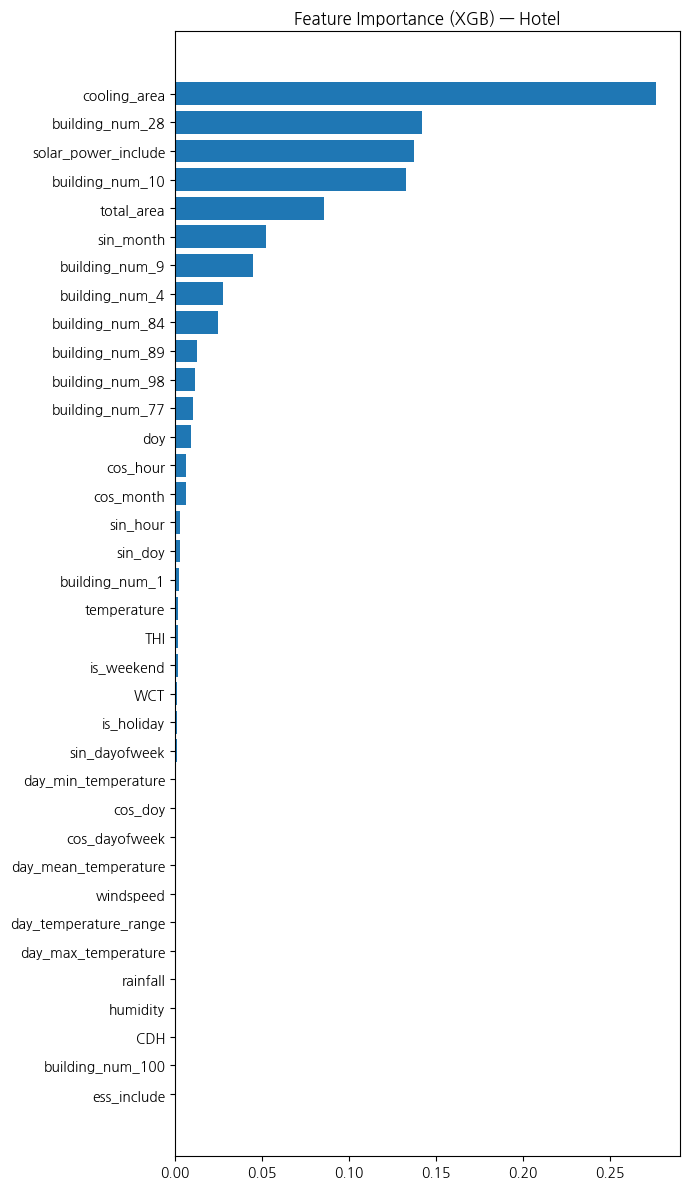

>> [Hotel] mean SMAPE (blend): 47.723

===== Building Type: Commercial =====
  Fold 1: SMAPE xgb=35.881, hgb=35.448, blend=35.447
  Fold 2: SMAPE xgb=37.116, hgb=34.291, blend=35.393
  Fold 3: SMAPE xgb=40.551, hgb=37.253, blend=38.703
  Fold 4: SMAPE xgb=24.958, hgb=39.055, blend=29.781
  Fold 5: SMAPE xgb=62.932, hgb=58.204, blend=60.414


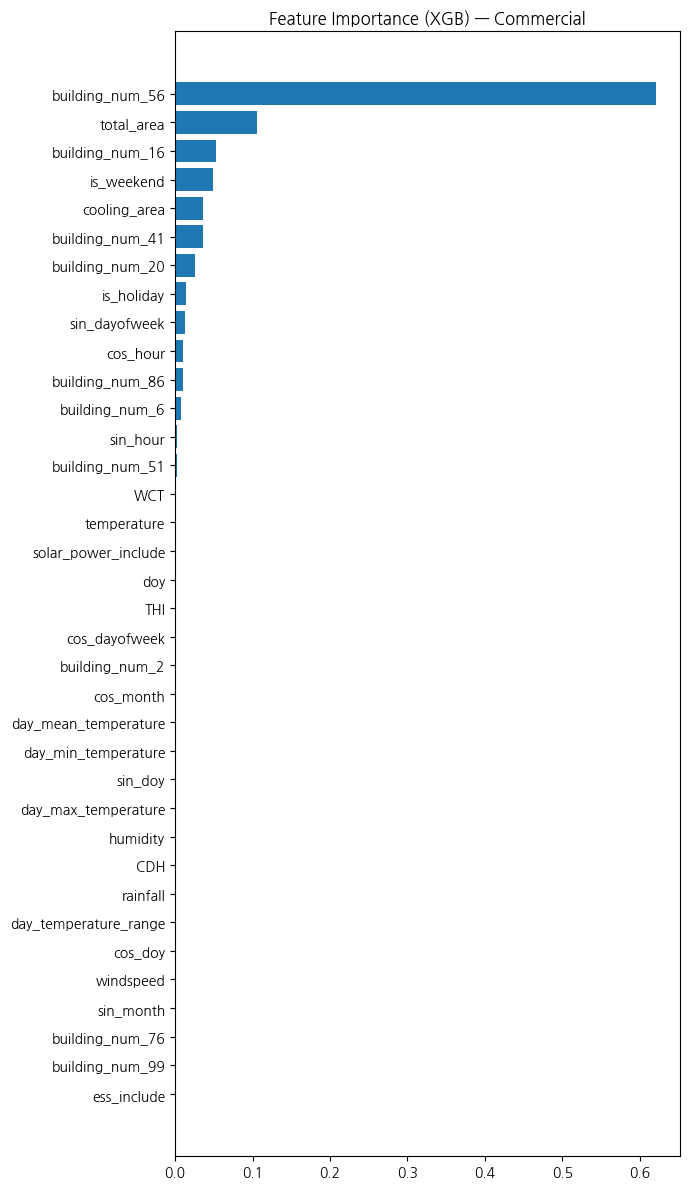

>> [Commercial] mean SMAPE (blend): 39.948

===== Building Type: Hospital =====
  Fold 1: SMAPE xgb=8.774, hgb=14.027, blend=10.465
  Fold 2: SMAPE xgb=33.151, hgb=33.549, blend=33.345
  Fold 3: SMAPE xgb=27.476, hgb=20.750, blend=23.695
  Fold 4: SMAPE xgb=34.726, hgb=23.218, blend=20.137
  Fold 5: SMAPE xgb=16.728, hgb=32.432, blend=22.507


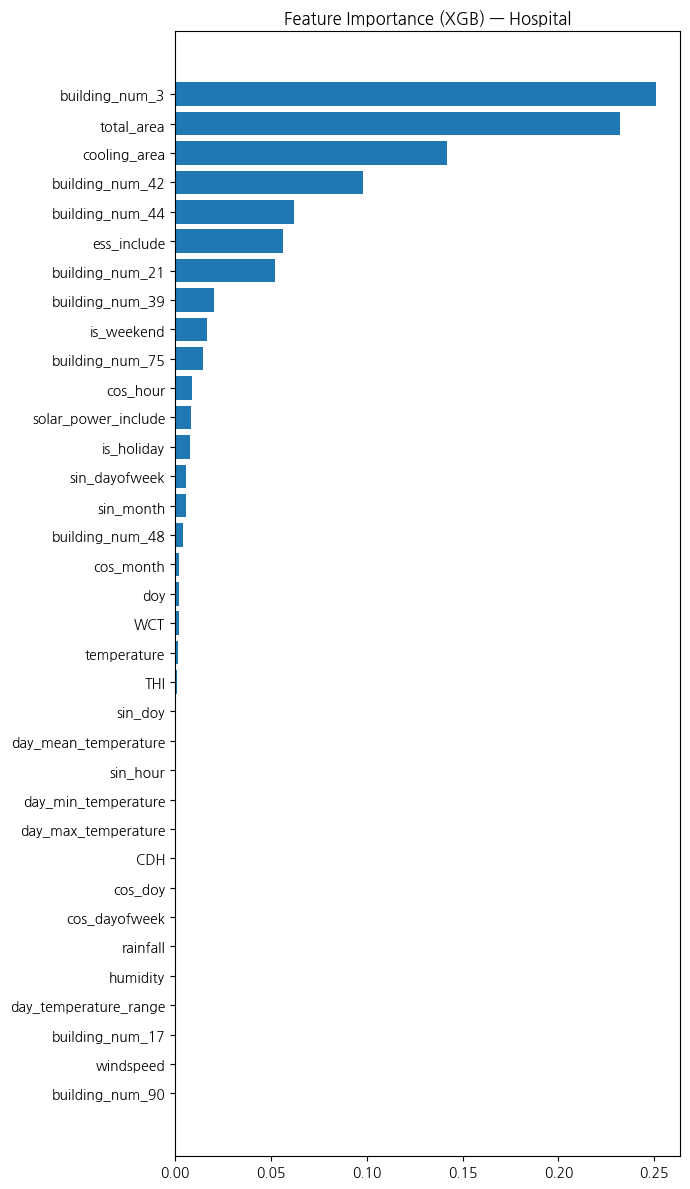

>> [Hospital] mean SMAPE (blend): 22.030

===== Building Type: University =====
  Fold 1: SMAPE xgb=26.946, hgb=21.643, blend=23.914
  Fold 2: SMAPE xgb=57.211, hgb=61.748, blend=59.197
  Fold 3: SMAPE xgb=41.940, hgb=42.325, blend=19.616
  Fold 4: SMAPE xgb=95.209, hgb=47.136, blend=56.397
  Fold 5: SMAPE xgb=63.446, hgb=87.448, blend=76.513


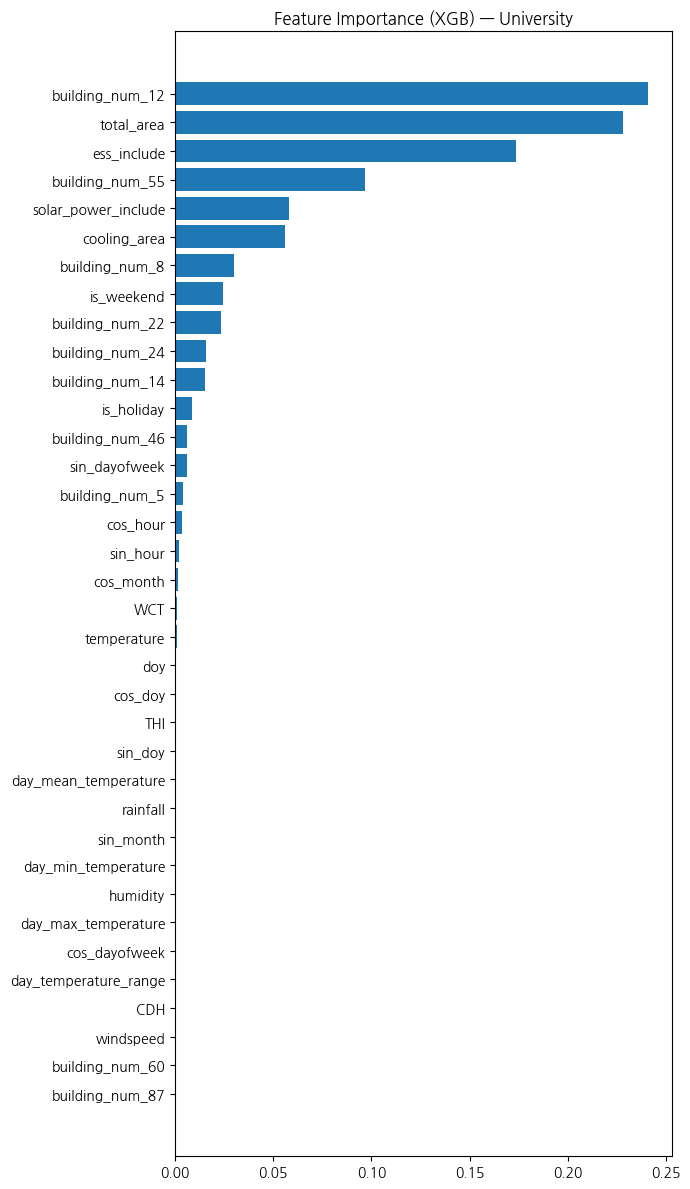

>> [University] mean SMAPE (blend): 47.127

===== Building Type: Other_building =====
  Fold 1: SMAPE xgb=88.976, hgb=89.140, blend=88.946
  Fold 2: SMAPE xgb=34.502, hgb=35.083, blend=34.276
  Fold 3: SMAPE xgb=82.846, hgb=93.798, blend=86.196
  Fold 4: SMAPE xgb=34.935, hgb=37.344, blend=35.783
  Fold 5: SMAPE xgb=23.539, hgb=22.851, blend=21.204


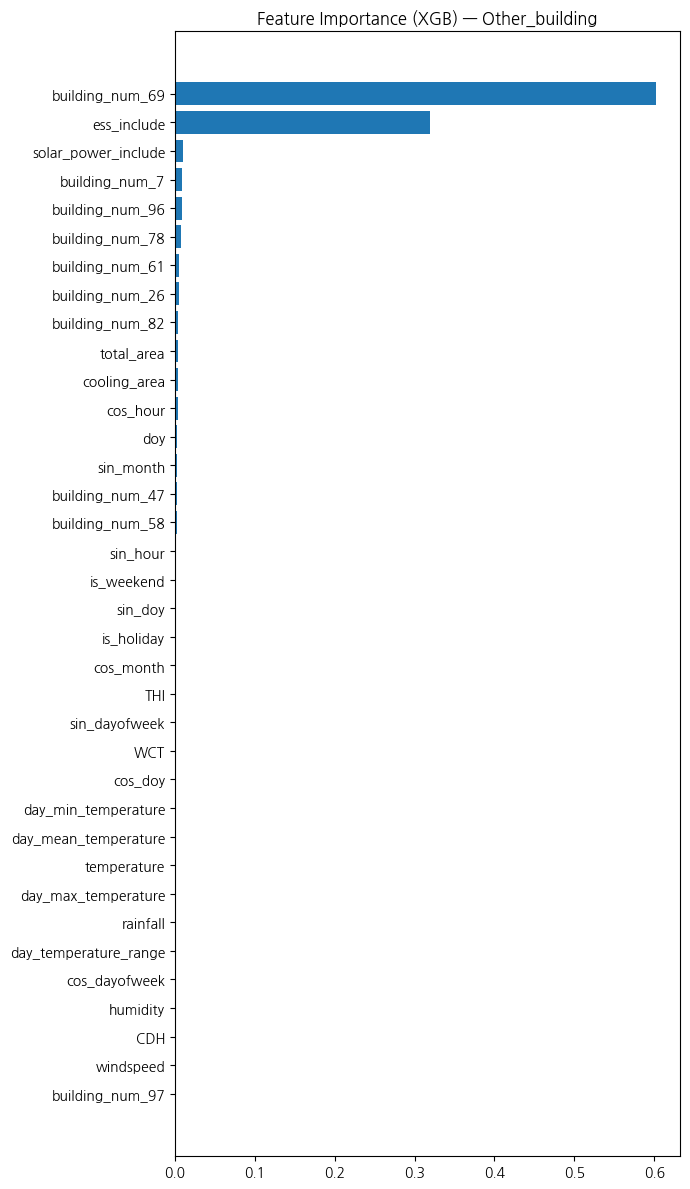

>> [Other_building] mean SMAPE (blend): 53.281

===== Building Type: Apartment =====
  Fold 1: SMAPE xgb=28.066, hgb=27.693, blend=27.837
  Fold 2: SMAPE xgb=149.125, hgb=149.953, blend=149.545
  Fold 3: SMAPE xgb=28.654, hgb=20.782, blend=23.874
  Fold 4: SMAPE xgb=138.894, hgb=138.781, blend=138.832
  Fold 5: SMAPE xgb=85.065, hgb=22.966, blend=33.106


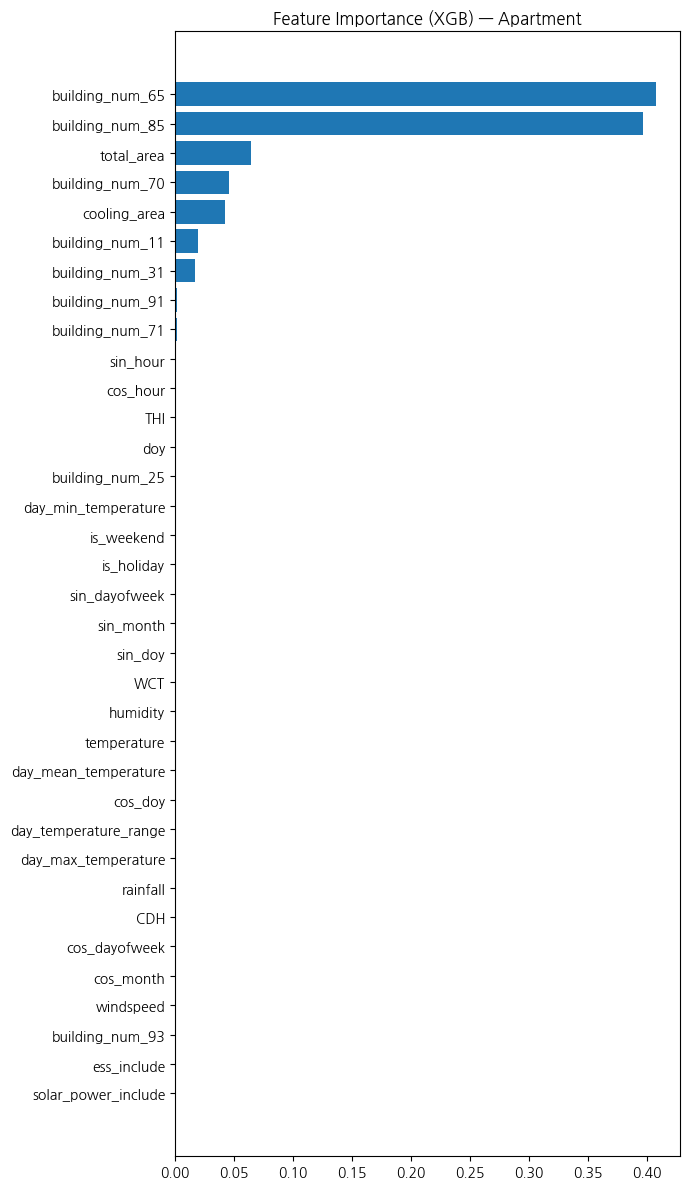

>> [Apartment] mean SMAPE (blend): 74.639

===== Building Type: Laboratory =====
  Fold 1: SMAPE xgb=34.494, hgb=35.480, blend=34.942
  Fold 2: SMAPE xgb=43.281, hgb=53.862, blend=48.324
  Fold 3: SMAPE xgb=27.639, hgb=36.984, blend=31.183
  Fold 4: SMAPE xgb=31.786, hgb=54.098, blend=38.098
  Fold 5: SMAPE xgb=10.968, hgb=11.361, blend=10.416


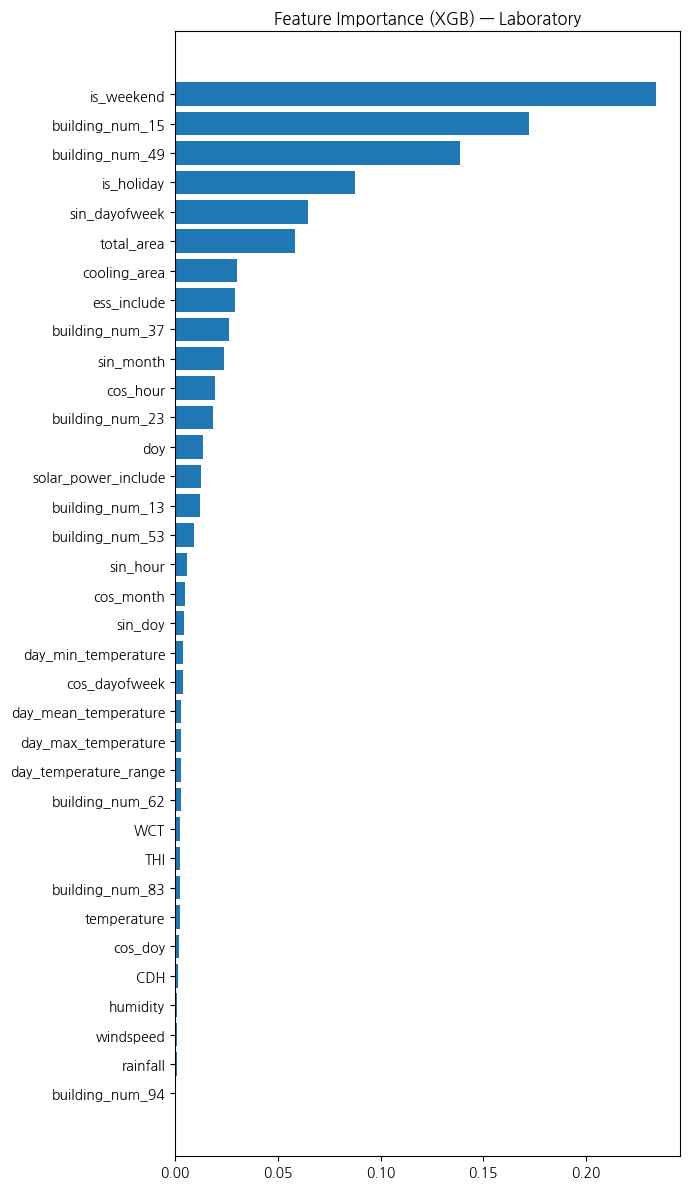

>> [Laboratory] mean SMAPE (blend): 32.592

===== Building Type: Department_store =====
  Fold 1: SMAPE xgb=39.360, hgb=39.591, blend=37.672
  Fold 2: SMAPE xgb=47.617, hgb=47.906, blend=47.661
  Fold 3: SMAPE xgb=38.865, hgb=80.274, blend=61.466
  Fold 4: SMAPE xgb=28.406, hgb=36.467, blend=31.567
  Fold 5: SMAPE xgb=23.816, hgb=24.030, blend=23.141


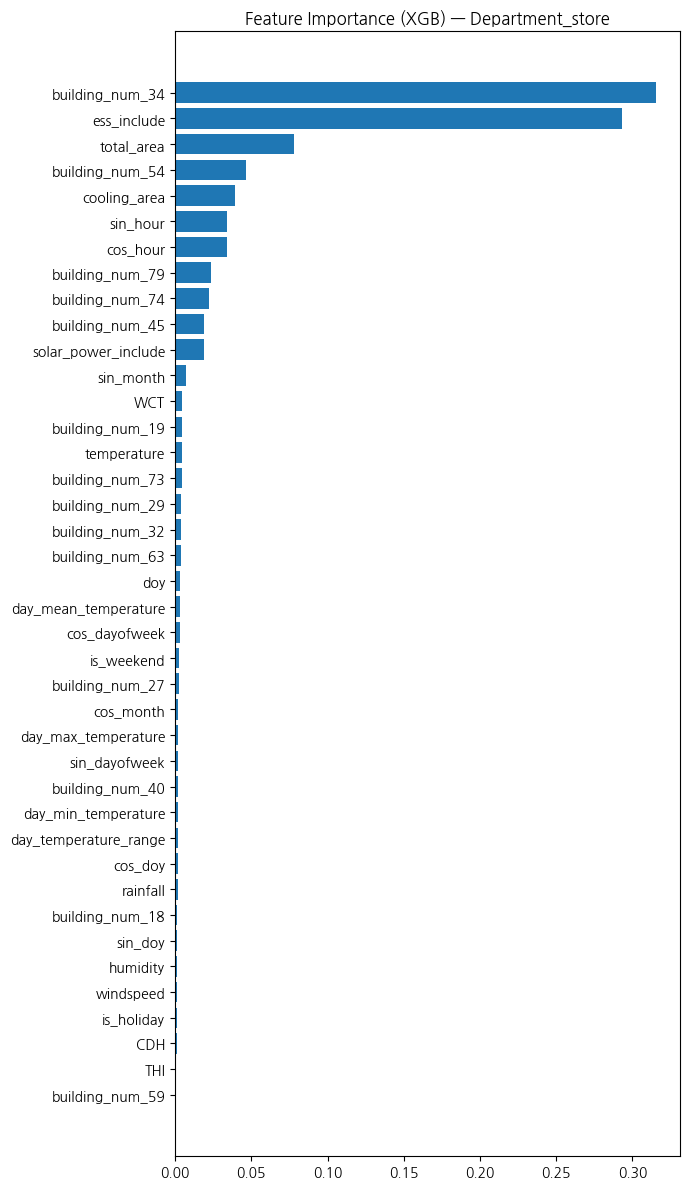

>> [Department_store] mean SMAPE (blend): 40.301

===== Building Type: IDC =====
  Fold 1: SMAPE xgb=22.802, hgb=22.692, blend=22.745
  Fold 2: SMAPE xgb=33.857, hgb=31.261, blend=31.823
  Fold 3: SMAPE xgb=62.631, hgb=70.921, blend=66.420
  Fold 4: SMAPE xgb=15.166, hgb=19.209, blend=16.815
  Fold 5: SMAPE xgb=115.889, hgb=117.166, blend=116.492


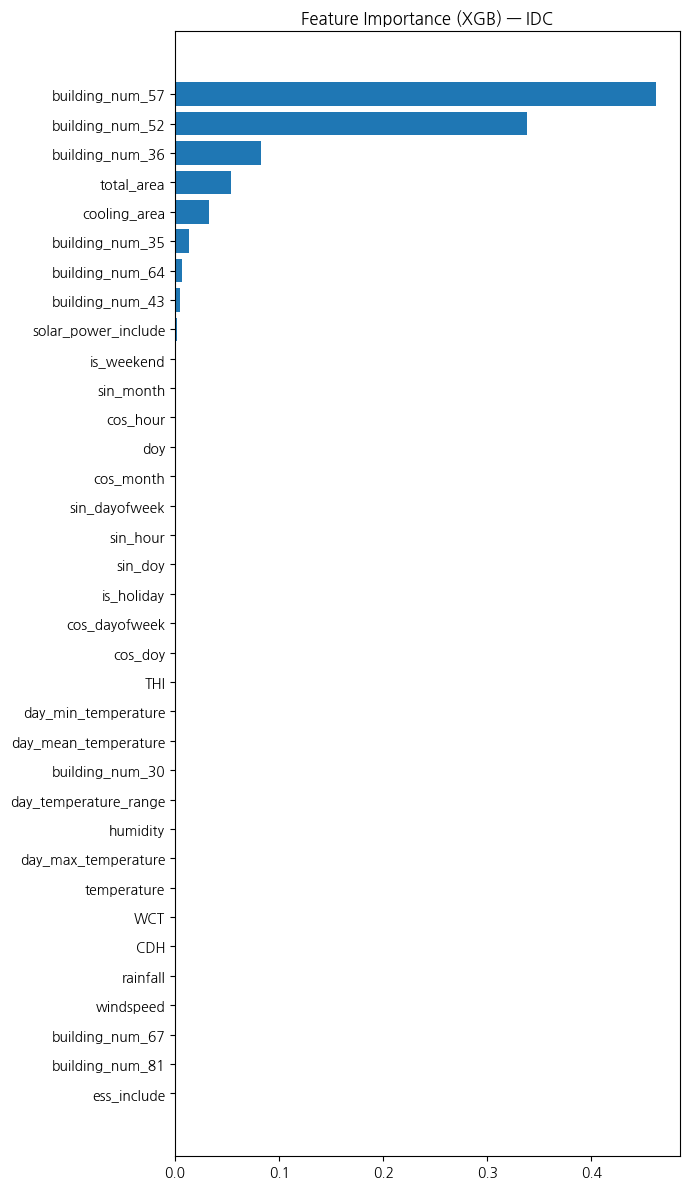

>> [IDC] mean SMAPE (blend): 50.859

===== Building Type: Public =====
  Fold 1: SMAPE xgb=31.839, hgb=36.866, blend=33.708
  Fold 2: SMAPE xgb=29.416, hgb=27.860, blend=27.681


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.experimental import enable_hist_gradient_boosting  # noqa: F401
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor


# =========================
# 0) 유틸
# =========================
def smape(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred))
    # 0 division 방지
    mask = denom > 0
    v = np.zeros_like(y_true, dtype=float)
    v[mask] = 2.0 * np.abs(y_pred[mask] - y_true[mask]) / denom[mask]
    return v.mean() * 100.0

def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

# =========================
# 1) 입력/타깃 분리
#    (여기서는 이미 전처리된 train/test를 사용한다고 가정)
#    - date_time, 원시 hour/day/month/dow 등은 제거했다고 가정
#    - building_type, building_number 존재
# =========================
TARGET = 'power_consumption'

# 학습 X/Y
X_all = train.drop(columns=[TARGET,'hour','day','month','day_of_week','date_time'], errors='ignore').copy()
Y_all = train[TARGET].copy()

# 테스트 X
test_all = test.drop(columns=['hour','day','month','day_of_week','date_time'], errors='ignore').copy()

# 결과 컨테이너
answer_df = pd.DataFrame(index=test_all.index, columns=['answer'], dtype=float)
oof_df    = pd.DataFrame(index=X_all.index,   columns=['oof_pred'], dtype=float)

# =========================
# 2) 시계열 분할 설정
#    (기간 6~8월: 3개월 → 5~7 폴드 권장. 여기선 5 폴드 예시)
# =========================
N_SPLITS = 5
tscv = TimeSeriesSplit(n_splits=N_SPLITS)

# =========================
# 3) 유형별 루프
# =========================
type_list = X_all['building_type'].unique()

for btype in type_list:
    print(f'\n===== Building Type: {btype} =====')

    # 해당 유형 추출
    x  = X_all[X_all['building_type'] == btype].copy()
    y  = Y_all.loc[x.index].copy()
    xt = test_all[test_all['building_type'] == btype].copy()

    # 원‑핫: building_num (건물 고정효과)
    # 주의: train/test 열 일치
    x  = pd.get_dummies(x,  columns=['building_num'], drop_first=False)
    xt = pd.get_dummies(xt, columns=['building_num'], drop_first=False)
    xt = xt.reindex(columns=x.columns, fill_value=0)

    # 불필요 컬럼 제거
    drop_cols = ['building_type']  # 필터링용이었으니 제거
    x  = x.drop(columns=drop_cols, errors='ignore')
    xt = xt.drop(columns=drop_cols, errors='ignore')

    # 넘파이로 변환
    X_values = x.values
    y_values = y.values

    # OOF 저장용, test fold 예측 모음
    oof_preds   = np.zeros_like(y_values, dtype=float)
    test_blends = []

    fold_metrics = []

    # =========================
    # 4) 폴드 반복 (시계열)
    # =========================
    for fold, (tr_idx, va_idx) in enumerate(tscv.split(X_values), 1):
        X_tr, X_va = X_values[tr_idx], X_values[va_idx]
        y_tr, y_va = y_values[tr_idx], y_values[va_idx]

        # 로그 안정화
        y_tr_log = np.log1p(y_tr)
        y_va_log = np.log1p(y_va)

        # ---- Base Model A: XGBoost
        xgb = XGBRegressor(
            n_estimators=4000,
            learning_rate=0.03,
            max_depth=9,
            subsample=0.8,
            colsample_bytree=0.7,
            min_child_weight=3,
            reg_lambda=1.0,
            objective='reg:squarederror',
            tree_method='gpu_hist',         # GPU 없을 때 안전. GPU면 'gpu_hist'로 바꿔도 됨
            random_state=42
        )
        xgb.fit(X_tr, y_tr_log,
                eval_set=[(X_va, y_va_log)],
                verbose=False)

        va_pred_xgb  = np.expm1(xgb.predict(X_va))
        test_pred_xgb = np.expm1(xgb.predict(xt.values))

        # ---- Base Model B: HistGradientBoosting (sklearn)
        hgb = HistGradientBoostingRegressor(
            max_depth=None,         # leaf-wise 깊이 제한 없음(트리 수는 내부적으로 결정)
            learning_rate=0.04,
            max_iter=700,
            l2_regularization=0.0,
            min_samples_leaf=20,
            random_state=42
        )
        hgb.fit(X_tr, y_tr_log)
        va_pred_hgb   = np.expm1(hgb.predict(X_va))
        test_pred_hgb = np.expm1(hgb.predict(xt.values))

        # ---- 폴드별 성능 (원 스케일)
        s1 = smape(y_va, va_pred_xgb)
        s2 = smape(y_va, va_pred_hgb)

        # 가중치: 작은 SMAPE에 더 큰 가중(역수)
        w1 = 1.0 / (s1 + 1e-6)
        w2 = 1.0 / (s2 + 1e-6)

        va_blend   = (w1 * va_pred_xgb   + w2 * va_pred_hgb)   / (w1 + w2)
        test_blend = (w1 * test_pred_xgb + w2 * test_pred_hgb) / (w1 + w2)

        # OOF 저장
        oof_preds[va_idx] = va_blend
        test_blends.append(test_blend)

        fold_s = smape(y_va, va_blend)
        fold_metrics.append(fold_s)
        print(f'  Fold {fold}: SMAPE xgb={s1:.3f}, hgb={s2:.3f}, blend={fold_s:.3f}')

        # (선택) 마지막 폴드 중요도 시각화
        if fold == N_SPLITS:
            importances = xgb.feature_importances_
            order = np.argsort(importances)
            plt.figure(figsize=(7, 12))
            plt.barh(x.columns[order][-40:], importances[order][-40:])  # 상위 40개만
            plt.title(f'Feature Importance (XGB) — {btype}')
            plt.tight_layout()
            plt.show()

    # 유형별 OOF/TEST 반영
    oof_df.loc[x.index, 'oof_pred'] = oof_preds
    answer_df.loc[xt.index, 'answer'] = np.mean(test_blends, axis=0)

    print(f'>> [{btype}] mean SMAPE (blend): {np.mean(fold_metrics):.3f}')

# =========================
# 5) 전체 OOF 성능
# =========================
total = smape(train.loc[oof_df.index, TARGET].values,
              oof_df['oof_pred'].values)
print(f'\n==== Overall OOF SMAPE: {total:.3f} ====')

# =========================
# 6) 제출 파일 생성
# =========================
# sample_submission.csv를 같은 스키마로 읽어서 채우기
# (num_date_time, answer)
sub = pd.read_csv("/content/drive/MyDrive/dacon_2025_Power_usage_prediction_AI/dacon_data/sample_submission.csv")  # 경로 맞춰서 변경
sub['answer'] = answer_df.loc[sub.index, 'answer'].values
sub.to_csv("/content/drive/MyDrive/dacon_2025_Power_usage_prediction_AI/dacon_data/sample_submission_private_son2.csv", index=False)
print('Saved -> sample_submission_private_son2.csv')


In [ ]:
!git status
!git add 02_EDAandPreprocessing.ipynb
!git commit -m "실험적 모델링"
!git push origin main